<a href="https://colab.research.google.com/github/nasifsadiq/Shooting-Aircraft-Simulation-in-Space-using-OpenGL-with-Mid-Point-Line-and-Circle-Drawing-Algorithm/blob/main/Shooting_Aircraft_Simulation_in_Space_using_OpenGL_with_Mid_Point_Line_and_Circle_Drawing_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q lucid>=0.2.3

In [ ]:
import numpy as np

import ctypes.util
from lucid.misc.gl.glcontext import create_opengl_context

# Now it's safe to import OpenGL and EGL functions
import OpenGL.GL as gl
from OpenGL.GLU import *

# create_opengl_context() creates GL context that is attached to an
# offscreen surface of specified size. Note that rendering to buffers
# of different size and format is still possible with OpenGL Framebuffers.
#
# Users are expected to directly use EGL calls in case more advanced
# context management is required.
WIDTH, HEIGHT = 800,800
create_opengl_context((WIDTH, HEIGHT))
    
# OpenGL context is available here.

print(gl.glGetString(gl.GL_VERSION))
print(gl.glGetString(gl.GL_VENDOR)) 
#print(gl.glGetString(gl.GL_EXTENSIONS))

b'4.6.0 NVIDIA 460.32.03'
b'NVIDIA Corporation'


###Axis and Cordinate (For Ease of Calculation)

In [ ]:
def point(a,b):
    gl.glVertex2f(a/(WIDTH/2), b/(HEIGHT/2))

def drawXYaxis():
    gl.glColor3f(0, 255, 0)
    gl.glPointSize(5)
    gl.glBegin(gl.GL_LINES)
    point(0,HEIGHT/2)
    point(0,-HEIGHT/2)
    gl.glEnd()

    gl.glColor3f(0, 255, 0)
    gl.glBegin(gl.GL_LINES)
    point(WIDTH/2,0)
    point(-WIDTH/2,0)
    gl.glEnd()

drawXYaxis()

###Image Buffer Function

In [ ]:
from IPython.display import display
from PIL import Image
def imageBuffer():
    img_buf = gl.glReadPixelsub(0, 0, WIDTH, HEIGHT, gl.GL_RGB, gl.GL_UNSIGNED_BYTE)
    img = np.frombuffer(img_buf,np.uint8).reshape(HEIGHT, WIDTH, 3)[::-1]
    display(Image.fromarray(img,'RGB'))
    return

###Point Drawer

In [ ]:
def pointDrawer(listOfPoints,color=(1,1,1)):
    gl.glColor3f(*color)
    gl.glPointSize(2)
    gl.glBegin(gl.GL_POINTS)
    for p in listOfPoints:
        point(*p)
    gl.glEnd()

###Mid Point Line Drawing Algo

In [ ]:
def zoneFinder(point1,point2):
    x1,y1=point1
    x2,y2=point2
    dx=x2-x1
    dy=y2-y1
    if abs(dx)>=abs(dy):
        if dx>=0 and dy>=0:
            return 0
        elif dx<=0 and dy>=0:
            return 3
        elif dx<=0 and dy<=0:
            return 4
        elif dx>=0 and dy<=0:
            return 7
    else:
        if dx>=0 and dy>=0:
            return 1
        elif dx<=0 and dy>=0:
            return 2
        elif dx<=0 and dy<=0:
            return 5
        elif dx>=0 and dy<=0:
            return 6

def zoneConverterToZero(zone,point):
    x,y=point
    if zone==1:
        x,y=y,x
    elif zone==2:
        x,y=y,-x
    elif zone==3:
        x,y=-x,y
    elif zone==4:
        x,y=-x,-y
    elif zone==5:
        x,y=-y,-x
    elif zone==6:
        x,y=-y,x
    elif zone==7:
        x,y=x,-y
    point=(x,y)
    return point

def zoneConverterToOg(zone,point):
    x,y=point
    if zone==1:
        x,y=y,x
    elif zone==2:
        x,y=-y,x
    elif zone==3:
        x,y=-x,y
    elif zone==4:
        x,y=-x,-y
    elif zone==5:
        x,y=-y,-x
    elif zone==6:
        x,y=y,-x
    elif zone==7:
        x,y=x,-y
    point=(x,y)
    return point

def midPointAlgo(point1,point2):
    x1,y1=point1
    x2,y2=point2
    pointList=[point1]
    dx=x2-x1
    dy=y2-y1
    D=(2*dy-dx)
    DeltaNE=2*(dy-dx)
    DeltaE=2*dy
    while True:
        x1+=1
        if D>0:
            y1+=1
            D+=DeltaNE
        else:
            D+=DeltaE
        pointList.append((x1,y1))
        if x1==x2 and y1==y2:
            break
    return pointList


def findAllOgPoints(ogZone,pointList):
    OgPointList=[]
    for p in pointList:
        OgPointList.append(zoneConverterToOg(ogZone,p))
    return OgPointList

def lineDrawer(point1,point2,color): #UserCall
    ogZone=zoneFinder(point1,point2)
    p1=zoneConverterToZero(ogZone,point1)
    p2=zoneConverterToZero(ogZone,point2)
    listOfZone0Points=midPointAlgo(p1,p2)
    listOfOgZonePoints=findAllOgPoints(ogZone,listOfZone0Points)
    pointDrawer(listOfOgZonePoints,color)
    return listOfOgZonePoints

###Mid Point Circle Drawing Algo

In [ ]:
import math as m
def zoneConverter(zone,point):
    a,b=point
    if zone==0:
        x,y=b,a
    elif zone==1:
        x,y=a,b
    elif zone==2:
        x,y=-a,b
    elif zone==3:
        x,y=-b,a
    elif zone==4:
        x,y=-b,-a
    elif zone==5:
        x,y=-a,-b
    elif zone==6:
        x,y=a,-b
    elif zone==7:
        x,y=b,-a
    point=(x,y)
    return point

def deltaE(x):
    return (2*x+3)
def deltaSE(x,y):
    return (2*x-2*y+5)


def midPointCircle(r):
    x=0
    d=1-r
    y=r
    listOfPoints=[]
    while x<y:
        if d<0:
            d+=deltaE(x)
            x+=1
        else:
            d+=deltaSE(x,y)
            x+=1
            y-=1
        listOfPoints.append((x,y))
    return listOfPoints


def scaling(listOfPoints,factor=0.5):
    scaledPoints=[]
    for x,y in listOfPoints:
        x*=factor
        y*=factor
        scaledPoints.append((x,y))
    return scaledPoints


def circleDrawer(r,centerX=0,centerY=0):
    zone1Points=midPointCircle(r)
    allZonePointsC0=[zoneConverter(k,p) for k in range(8) for p in zone1Points]
    allZonePointsCOG=[(x+centerX,y+centerY) for x,y in allZonePointsC0]
    pointDrawer(allZonePointsCOG)
    return allZonePointsCOG



###Paper Plane Fight

In [ ]:
def paperPlane1(planeColor=(1,1,1)):
    p1x=p3x=p4x=p5x=-(HEIGHT/2)+50
    p1y=50
    p2x=-(HEIGHT/2)+125
    p2y=0
    p3y=-50
    p4y=-10
    p5y=10
    p6x=-(HEIGHT/2)+35
    p6y=0
    pointsOfPaperPlane=[]
    p1=(p1x,p1y)
    p2=(p2x,p2y)
    p3=(p3x,p3y)
    p4=(p4x,p4y)
    p5=(p5x,p5y)
    p6=(p6x,p6y)
    paperPlanePoints=[]
    paperPlanePoints.extend(lineDrawer(p1,p2,planeColor))
    paperPlanePoints.extend(lineDrawer(p2,p3,planeColor))
    paperPlanePoints.extend(lineDrawer(p3,p4,planeColor))
    paperPlanePoints.extend(lineDrawer(p1,p5,planeColor))
    paperPlanePoints.extend(lineDrawer(p4,p6,planeColor))
    paperPlanePoints.extend(lineDrawer(p5,p6,planeColor))
    paperPlanePoints.extend(lineDrawer(p5,p2,planeColor))
    paperPlanePoints.extend(lineDrawer(p4,p2,planeColor))
    return paperPlanePoints

In [ ]:
def paperPlane2(planeColor=(1,1,1)):
    p3x=p2x=p7x=p8x=-(HEIGHT/2)+50
    p1x=p9x=-(HEIGHT/2)+20
    p4x=p6x=-(HEIGHT/2)+70
    p2y=p4y=10
    p1y=p3y=50
    p5x=-(HEIGHT/2)+125
    p8y=p6y=-10
    p7y=p9y=-50
    p5y=p10y=0
    p10x=-(HEIGHT/2)+40
    pointsOfPaperPlane=[]
    p1=(p1x,p1y)
    p2=(p2x,p2y)
    p3=(p3x,p3y)
    p4=(p4x,p4y)
    p5=(p5x,p5y)
    p6=(p6x,p6y)
    p7=(p7x,p7y)
    p8=(p8x,p8y)
    p9=(p9x,p9y)
    p10=(p10x,p10y)

    paperPlanePoints=[]
    paperPlanePoints.extend(lineDrawer(p1,p2,planeColor))
    paperPlanePoints.extend(lineDrawer(p2,p3,planeColor))
    paperPlanePoints.extend(lineDrawer(p3,p4,planeColor))
    paperPlanePoints.extend(lineDrawer(p4,p5,planeColor))
    paperPlanePoints.extend(lineDrawer(p5,p6,planeColor))
    paperPlanePoints.extend(lineDrawer(p6,p7,planeColor))
    paperPlanePoints.extend(lineDrawer(p7,p8,planeColor))
    paperPlanePoints.extend(lineDrawer(p8,p9,planeColor))
    paperPlanePoints.extend(lineDrawer(p9,p10,planeColor))
    paperPlanePoints.extend(lineDrawer(p10,p1,planeColor))
    return paperPlanePoints

In [ ]:
def movePaperPlaneY(offset,ppp,planeColor):
    paperPlanePoints=[(x,y+offset*20) for x,y in ppp]
    pointDrawer(paperPlanePoints,planeColor)
    return

In [ ]:
def fireBullet(offset,p,bulletColor):
    gl.glColor3f(*bulletColor)
    gl.glPointSize(10)
    gl.glBegin(gl.GL_POINTS)
    x,y=p
    point(x,y+offset*20)
    gl.glEnd()
    return (x,y+offset*20)

In [ ]:
def moveBullet(offset,listOfPoints,bulletColor):
    gl.glColor3f(*bulletColor)
    gl.glPointSize(10)
    gl.glBegin(gl.GL_POINTS)
    movedPoints=[]
    for x,y in listOfPoints:
        movedPoints.append((x+offset*20,y))
        point(x+offset*20,y)
        offset-=1
    gl.glEnd()
    return movedPoints

In [ ]:
def astroidOG():
    pointsOfCircleCOG=circleDrawer(100)
    return pointsOfCircleCOG

def astroid1(scalingFactor,centerX,centerY,listOfAP):
    pointsOfCircleC0=scaling(listOfAP,scalingFactor)
    pointsOfCircleCOG=[(x+centerX,y+centerY) for x,y in pointsOfCircleC0]
    return pointsOfCircleCOG
def astroid2(scalingFactor,centerX,centerY,listOfAP):
    pointsOfCircleC0=scaling(listOfAP,scalingFactor)
    pointsOfCircleCOG=[(x+centerX,y+centerY) for x,y in pointsOfCircleC0]
    return pointsOfCircleCOG
def astroid3(scalingFactor,centerX,centerY,listOfAP):
    pointsOfCircleC0=scaling(listOfAP,scalingFactor)
    pointsOfCircleCOG=[(x+centerX,y+centerY) for x,y in pointsOfCircleC0]
    return pointsOfCircleCOG

def moveAstroid(offset,pa):
    astroidPoints=[(x-offset*20,y) for x,y in pa]
    pointDrawer(astroidPoints)
    return astroidPoints

###Test Case

In [ ]:
gl.glClear(gl.GL_COLOR_BUFFER_BIT) #Clear ImageBuffer

Pick a color for bullet from Red,Green,Blue,White:red
Pick a color for plane from Red,Green,Blue,White:green
Select Type 1 or 2 Plane: 2


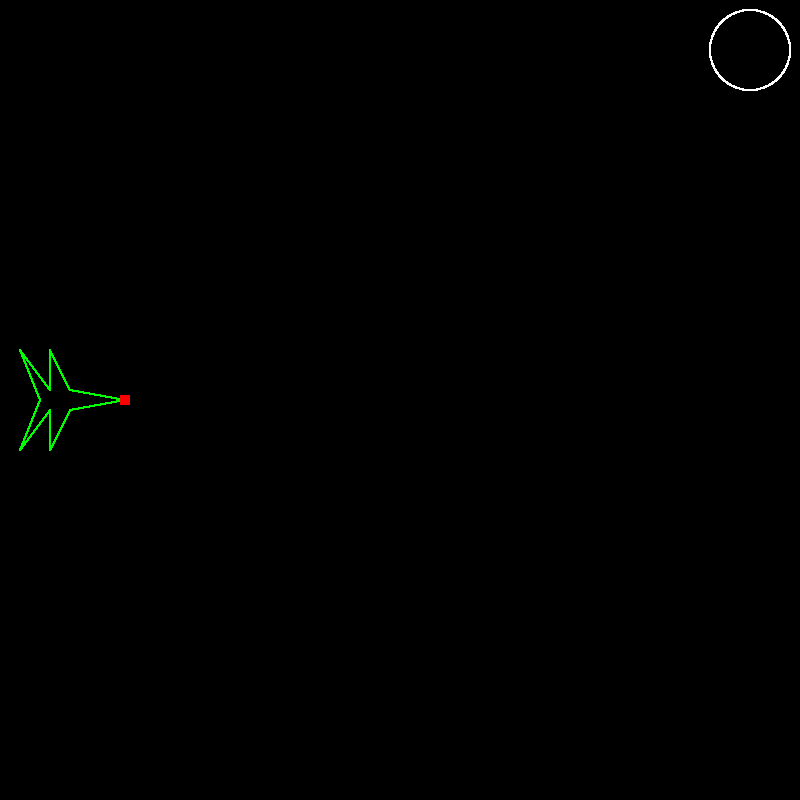

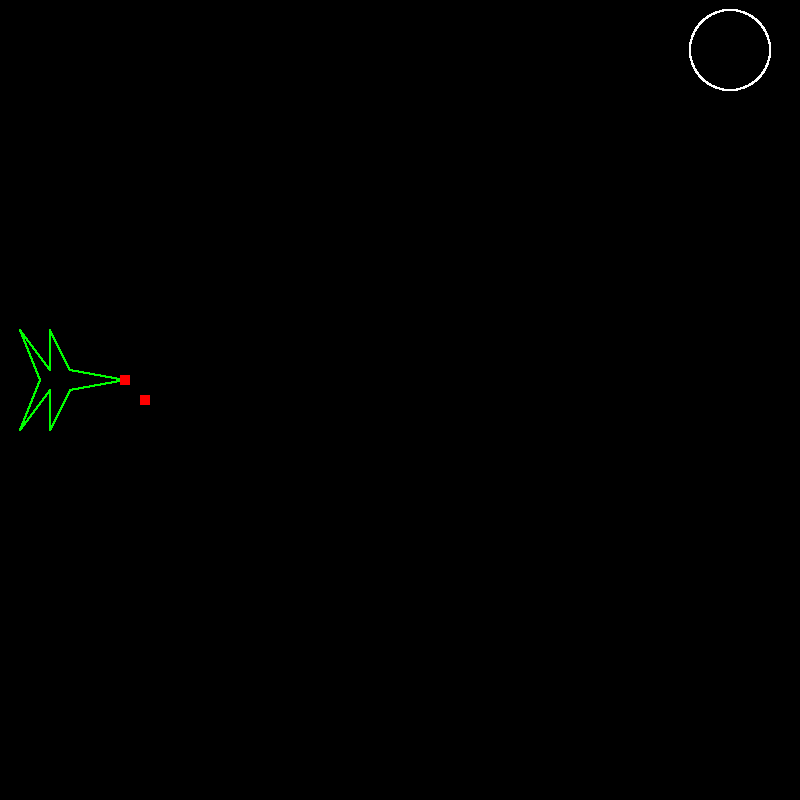

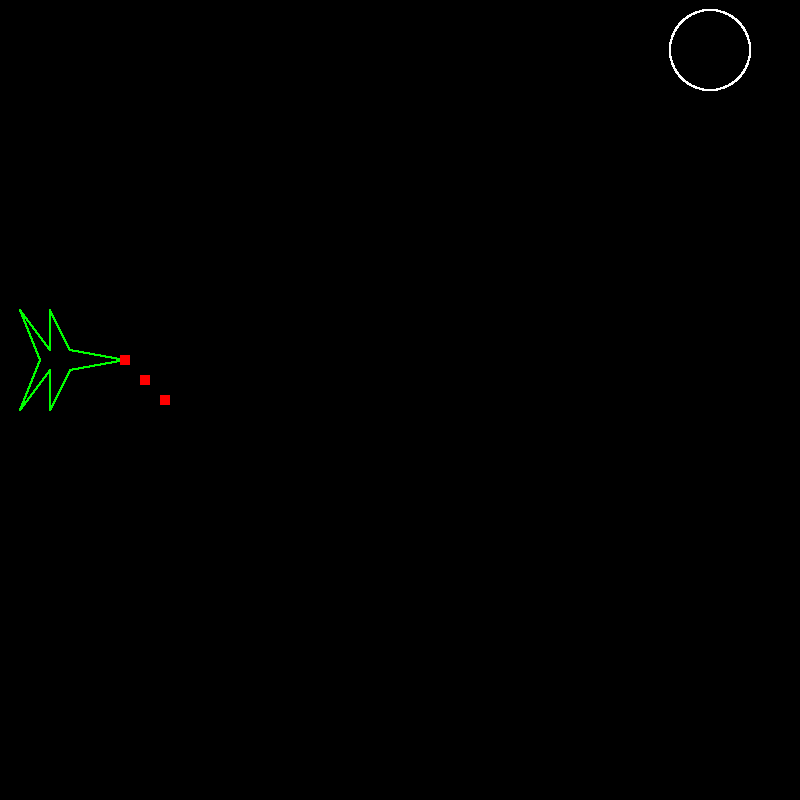

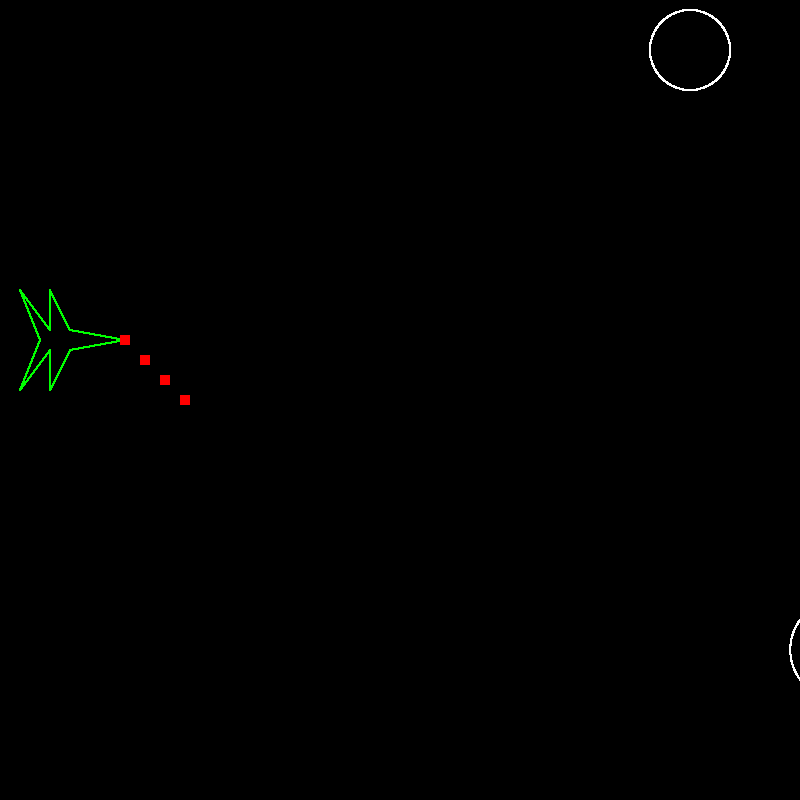

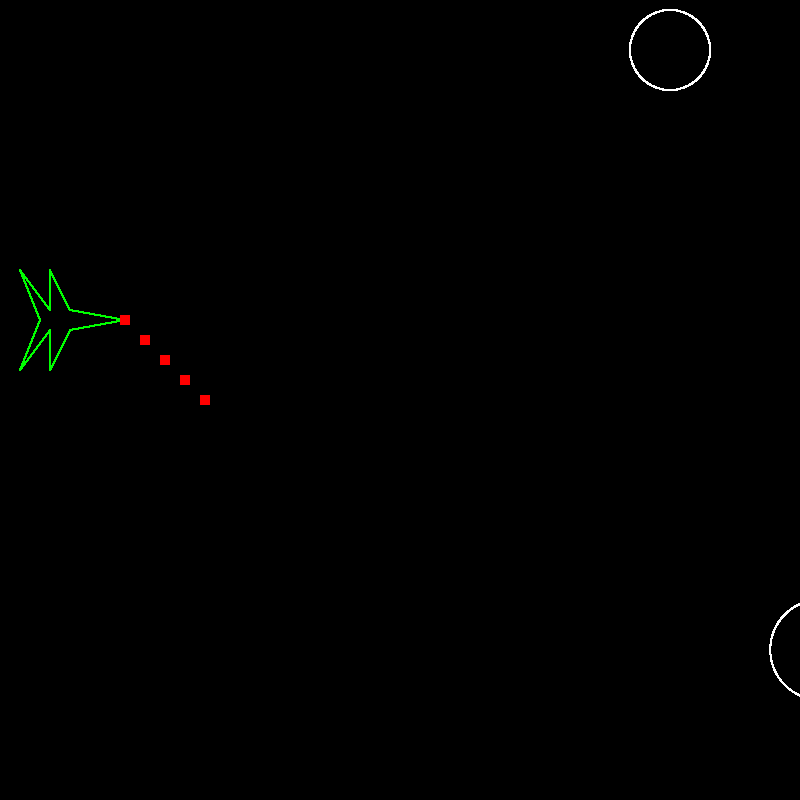

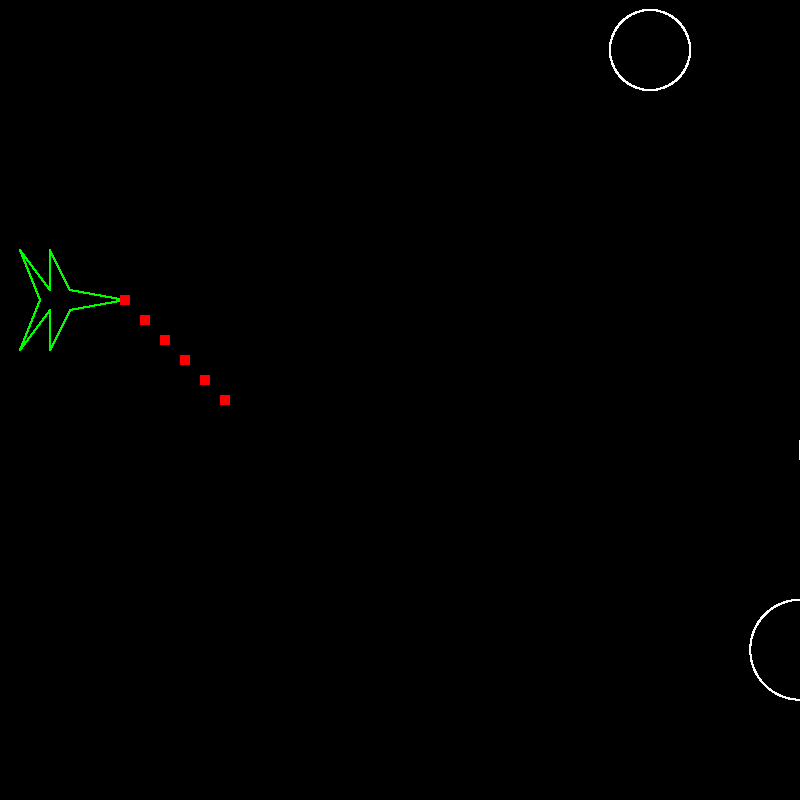

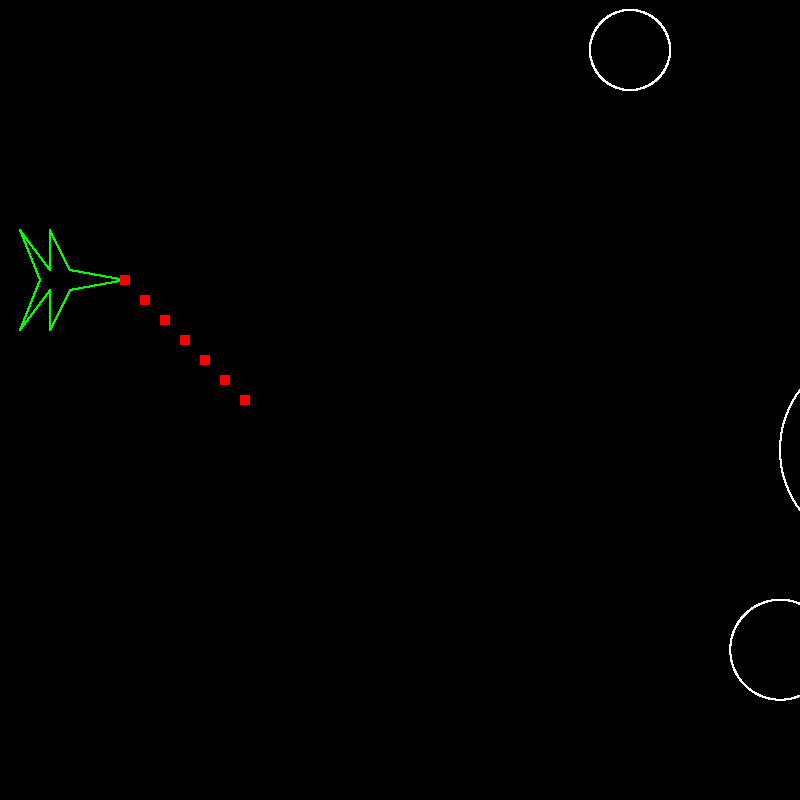

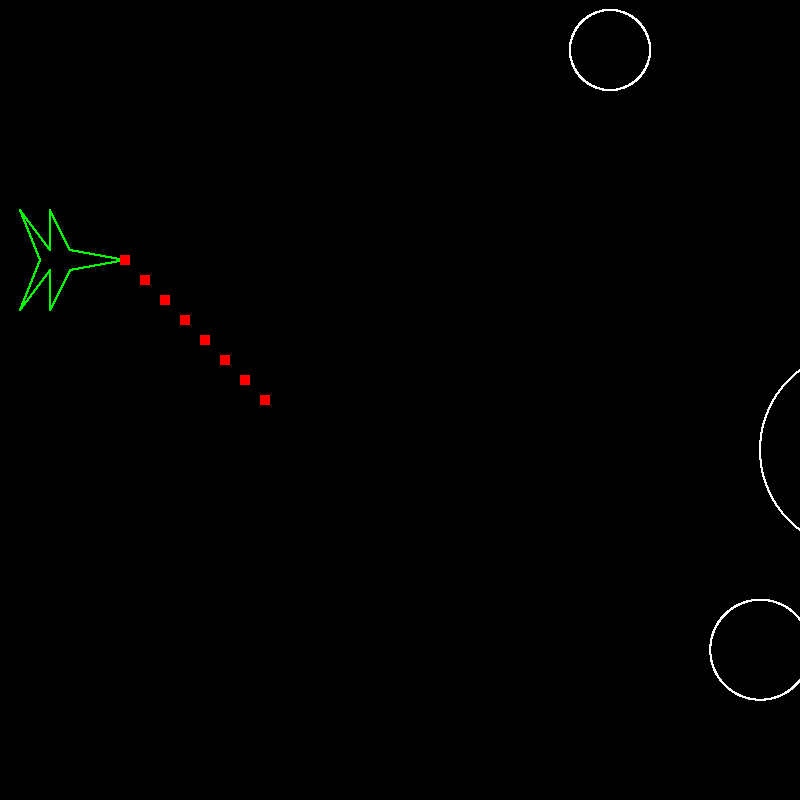

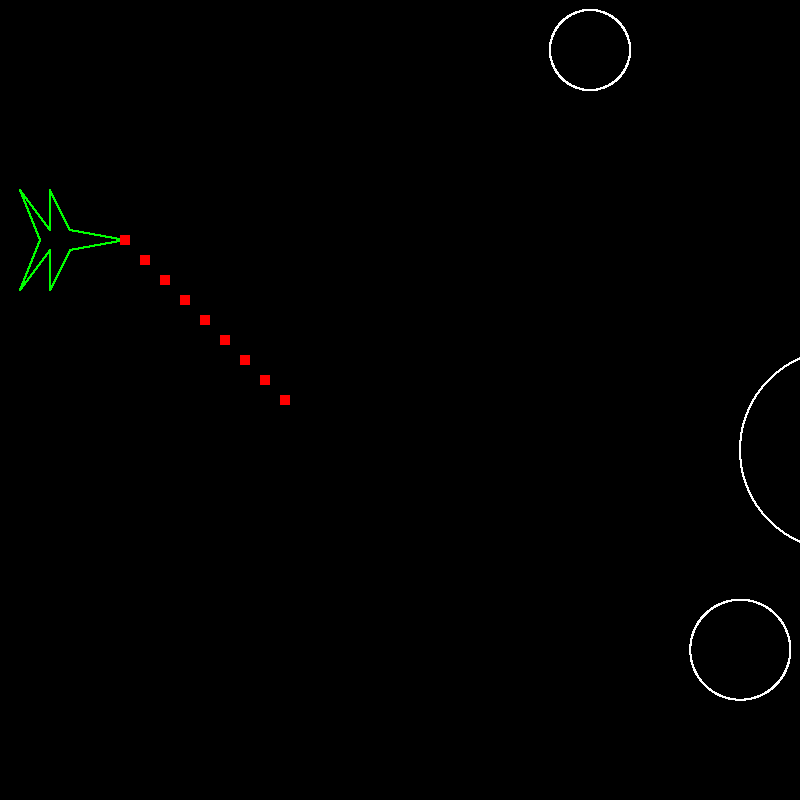

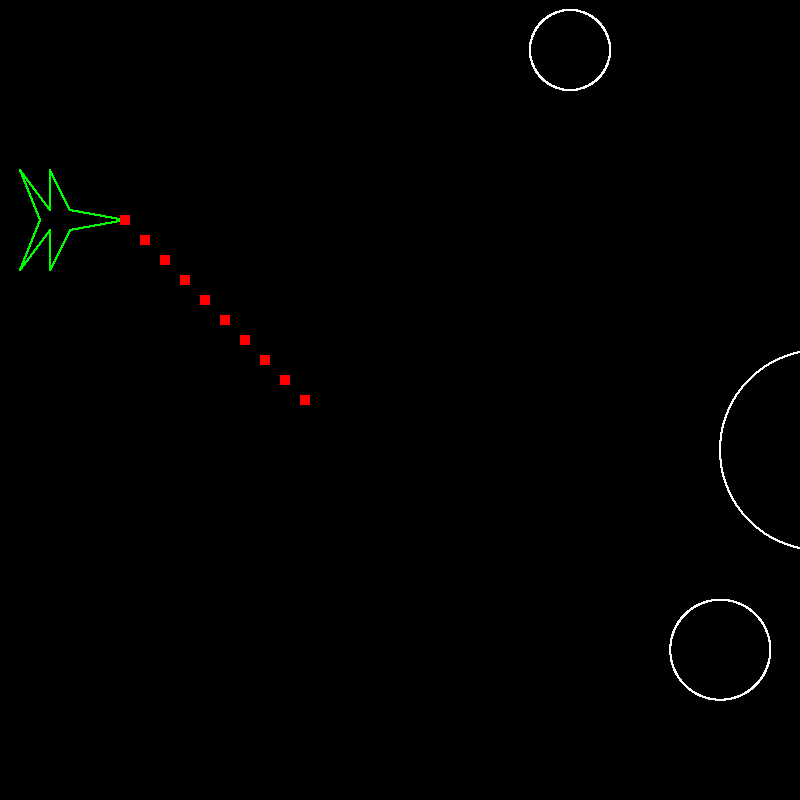

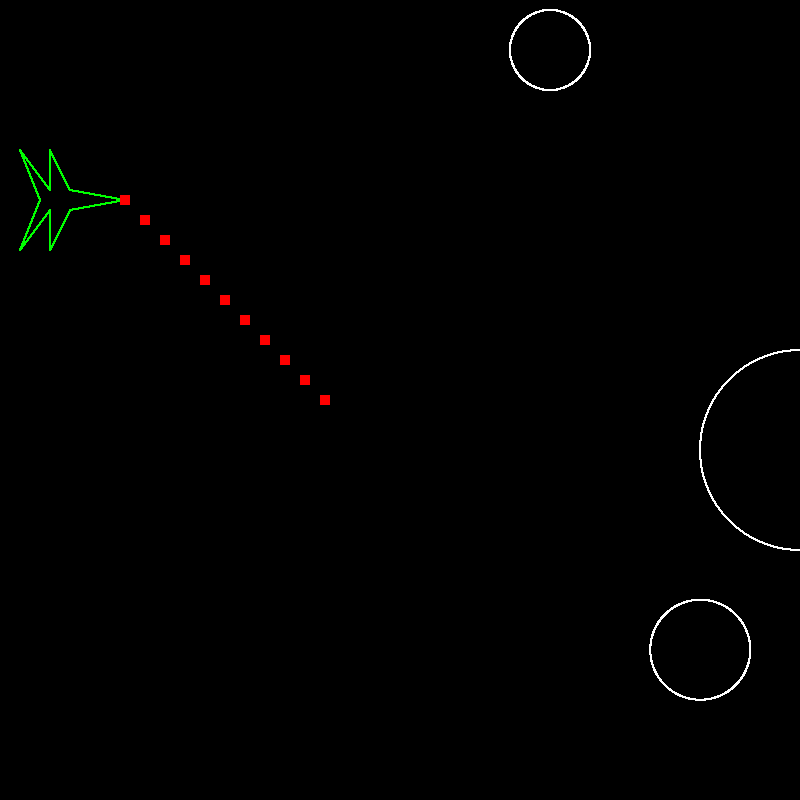

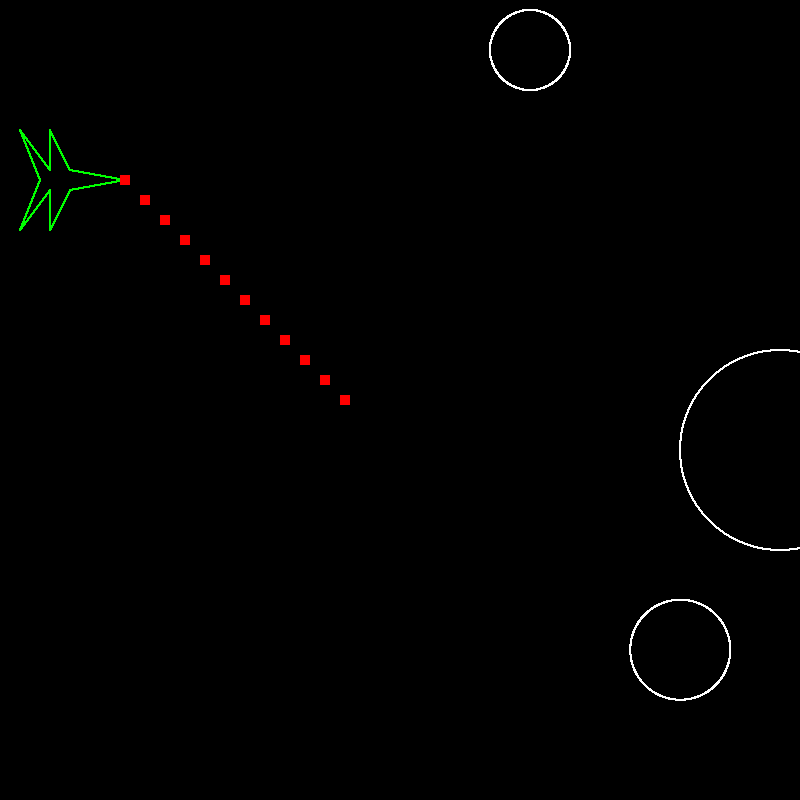

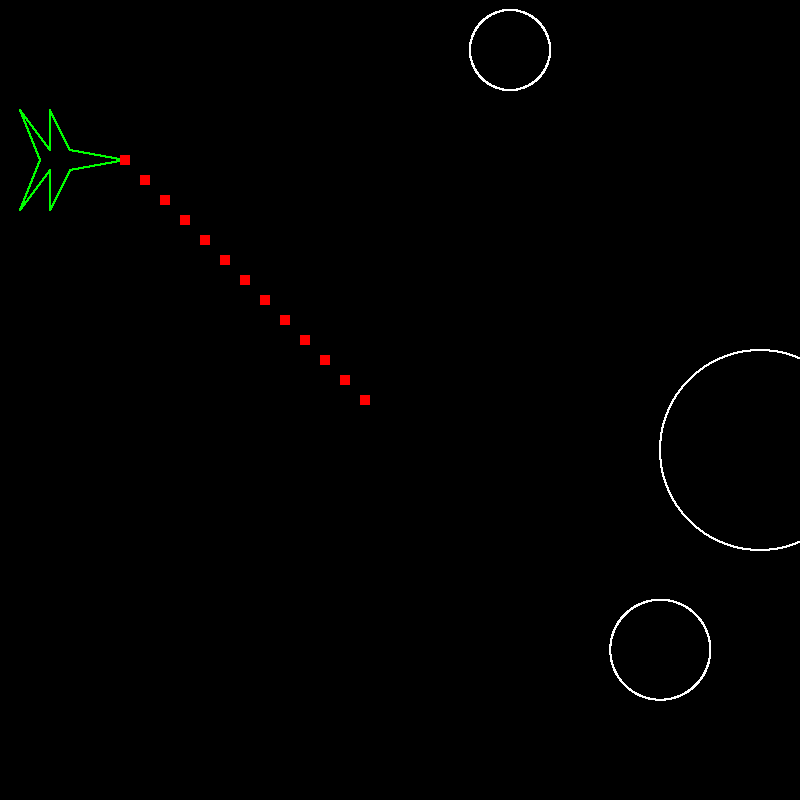

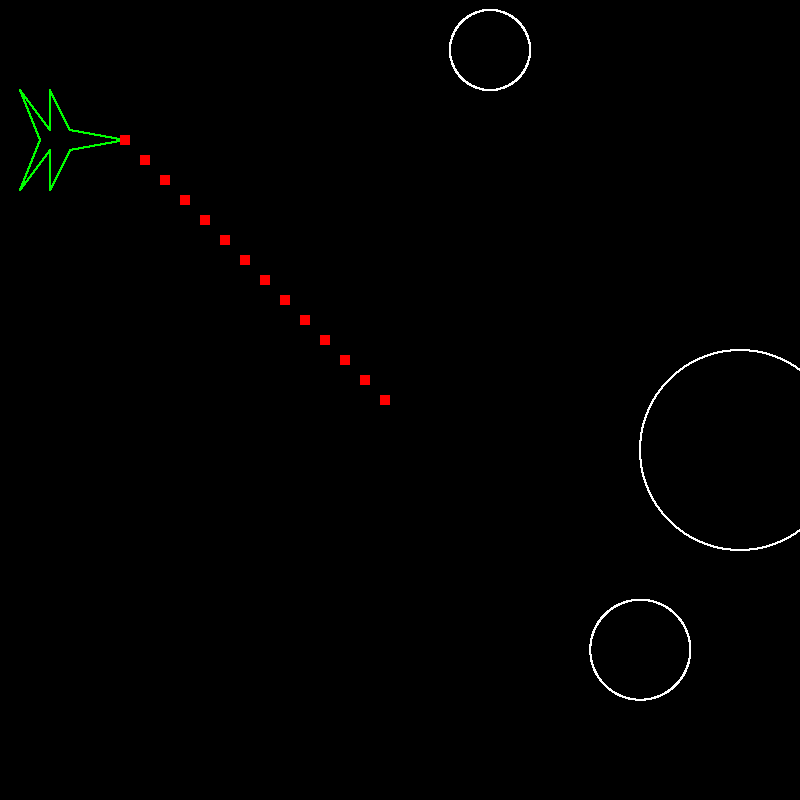

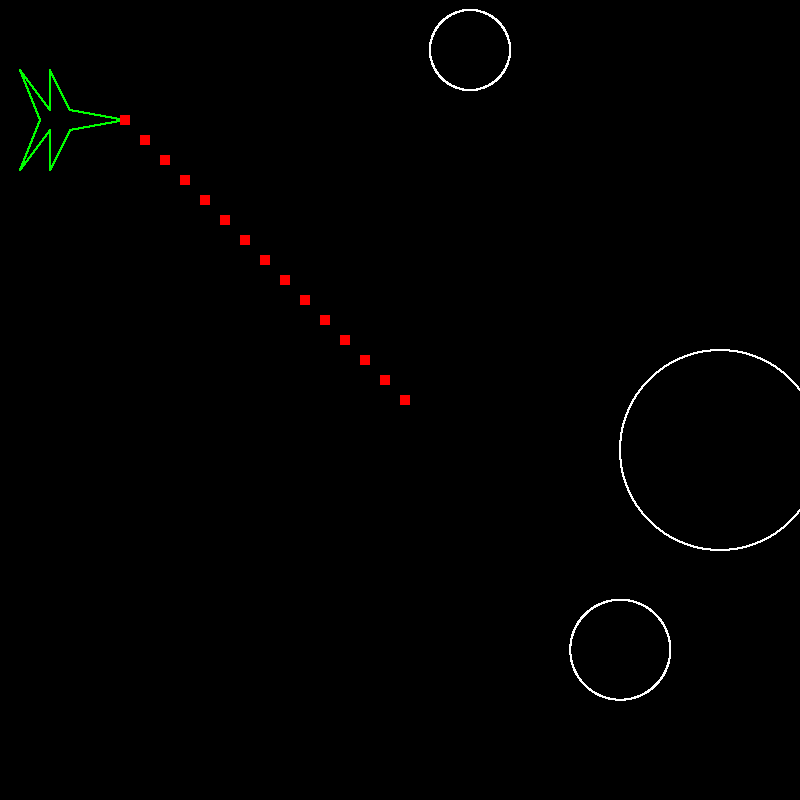

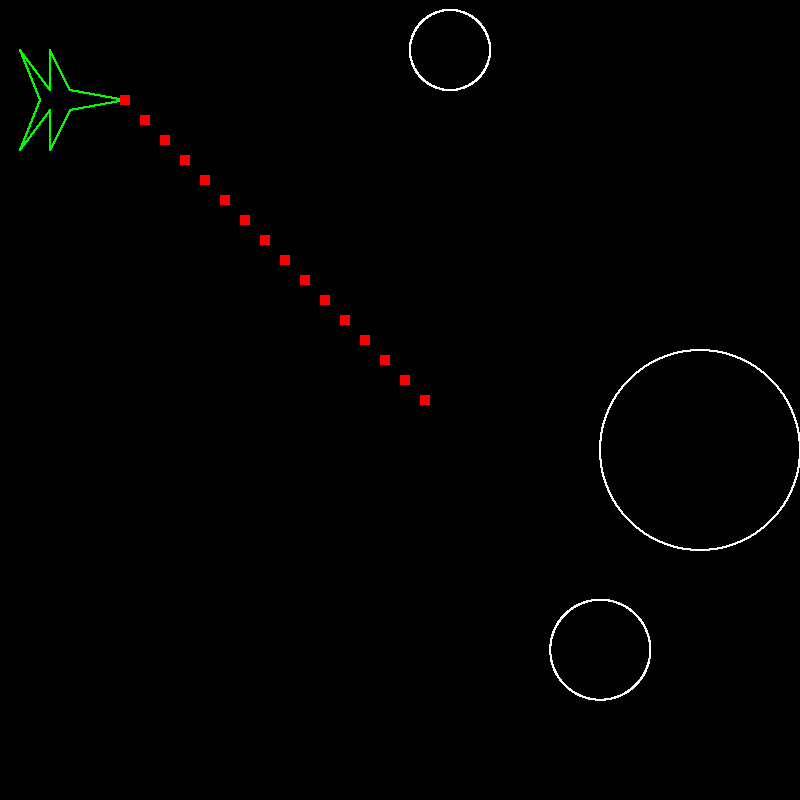

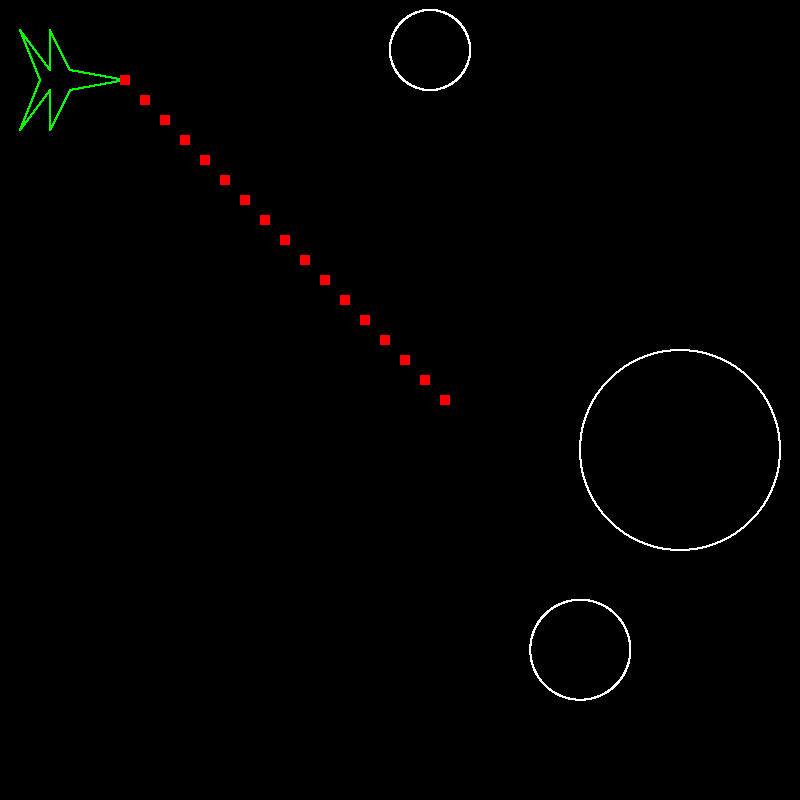

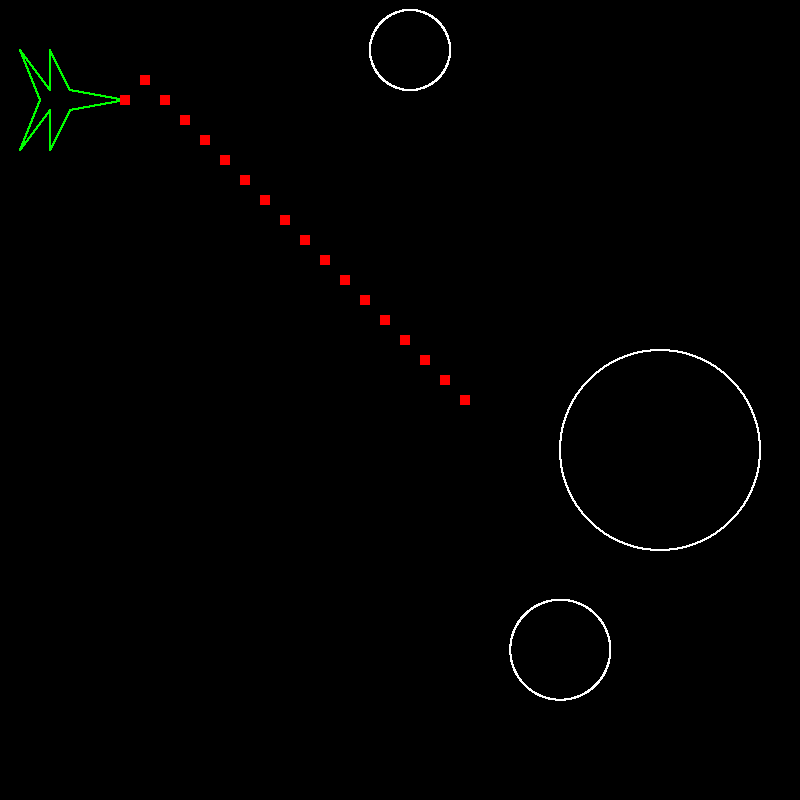

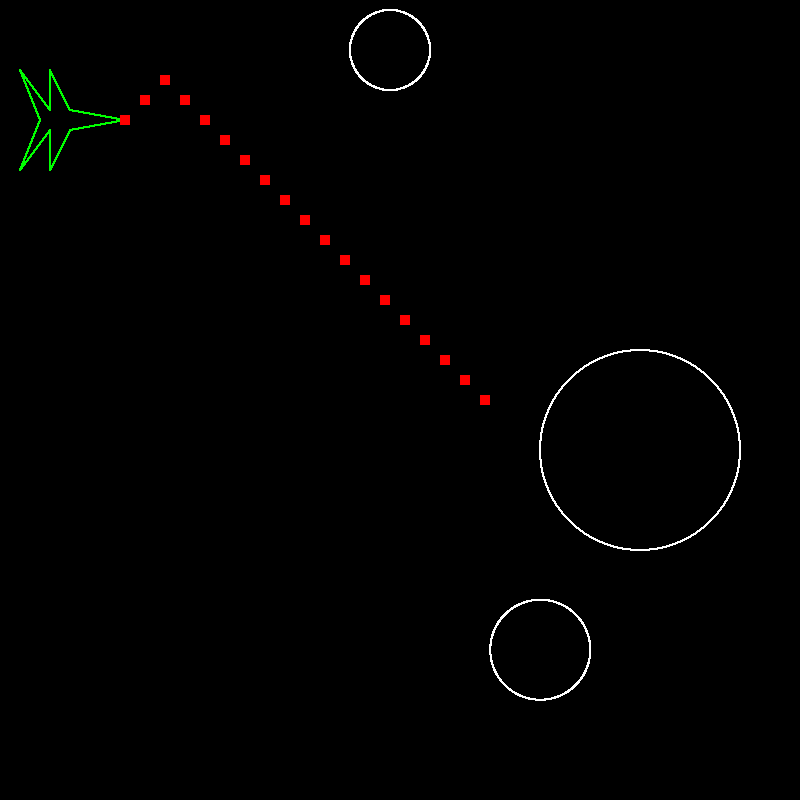

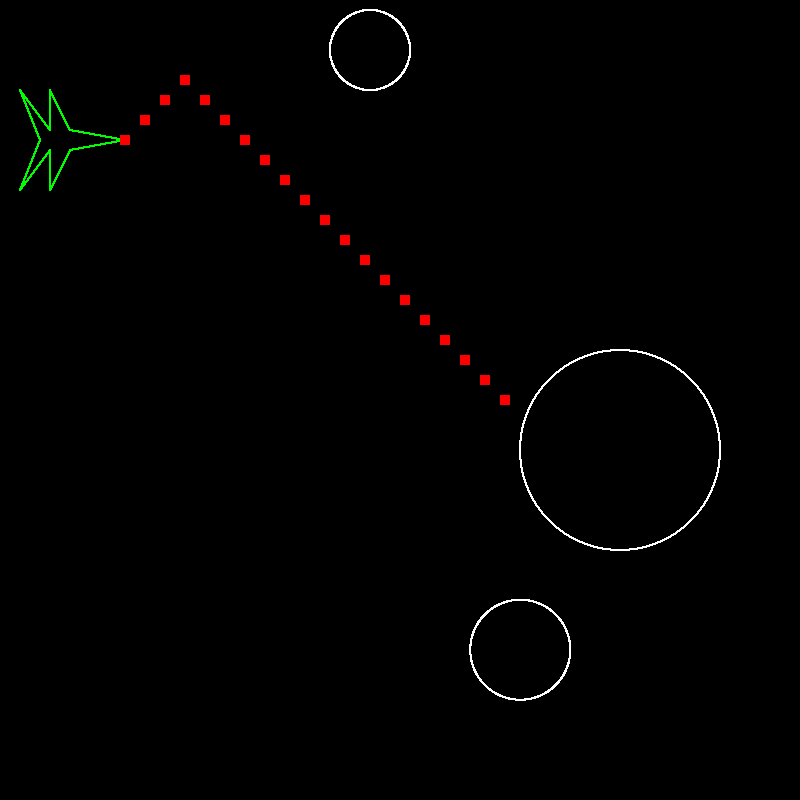

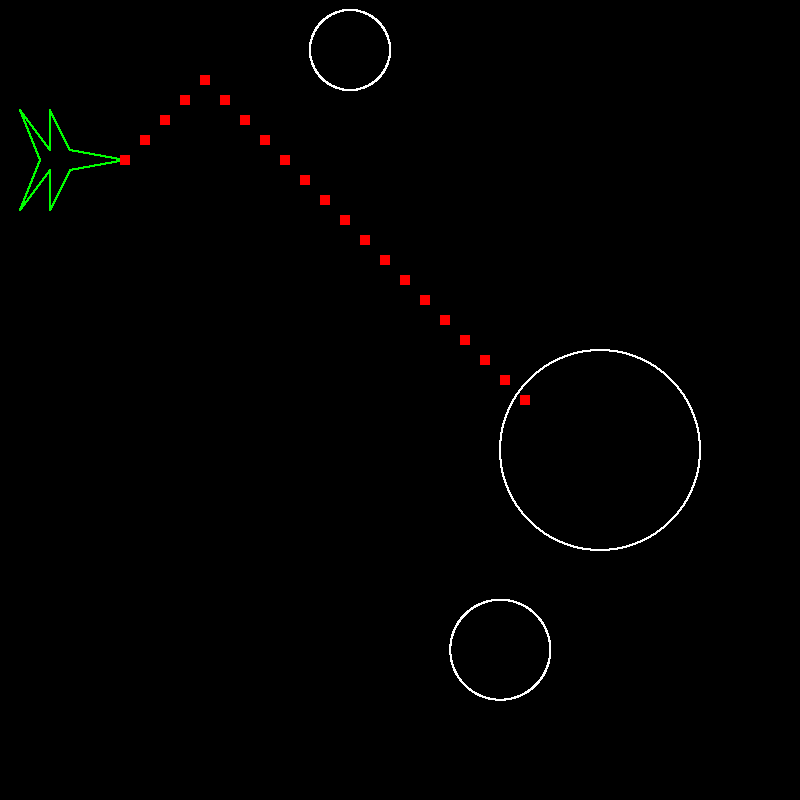

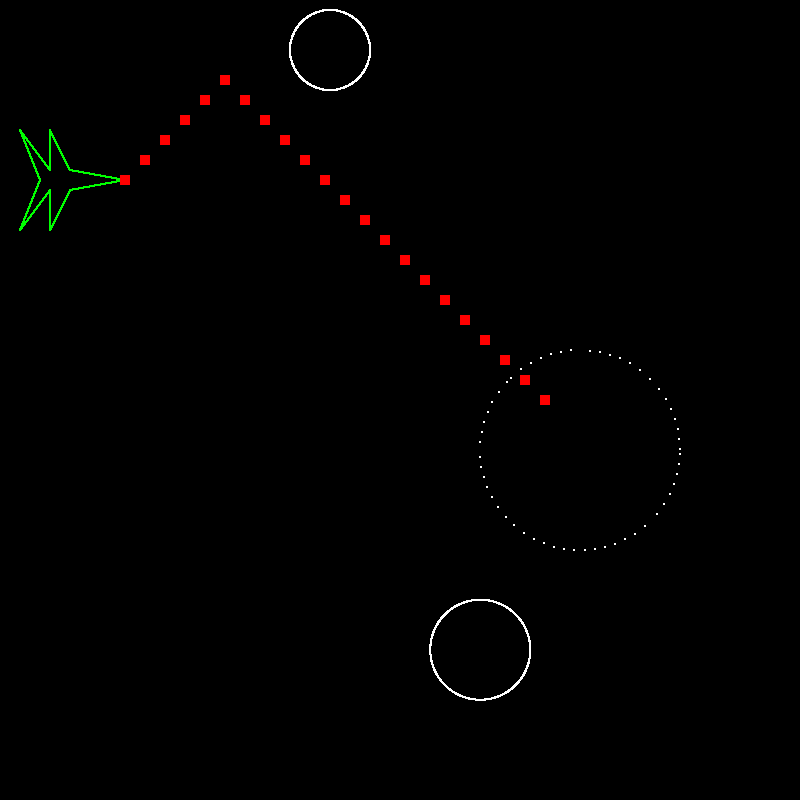

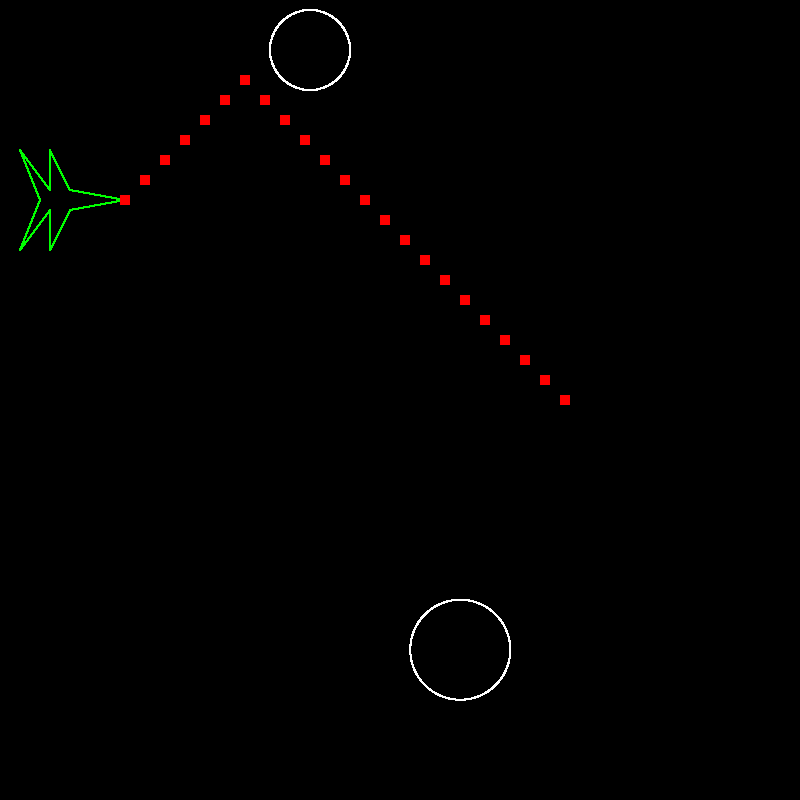

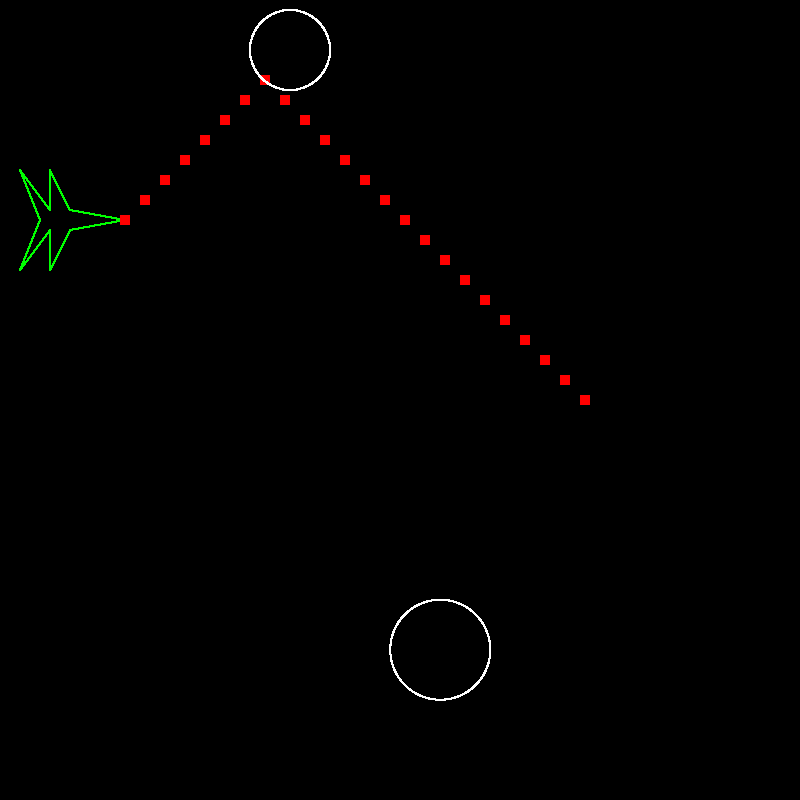

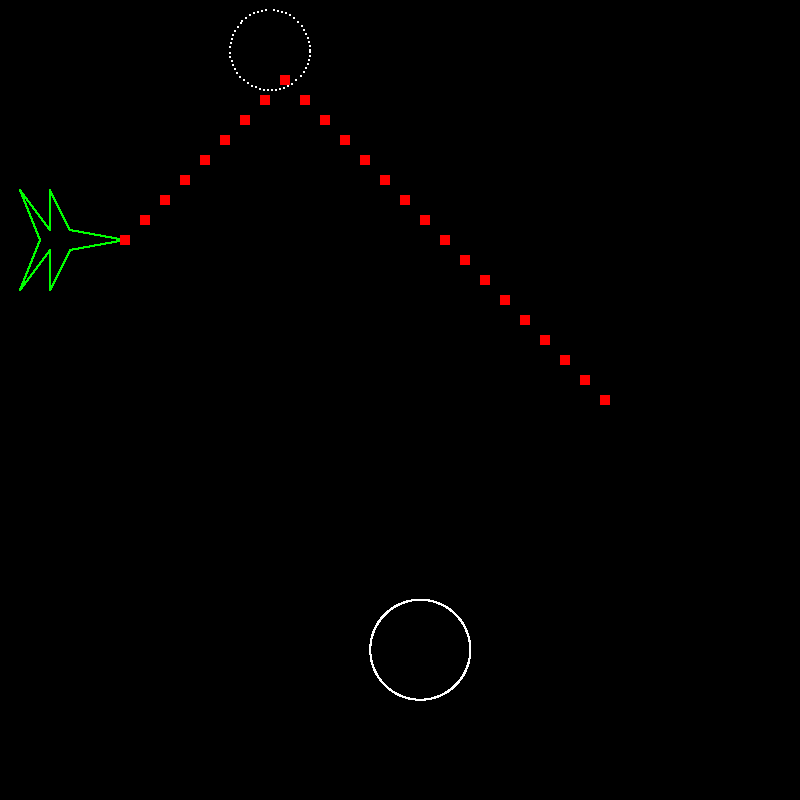

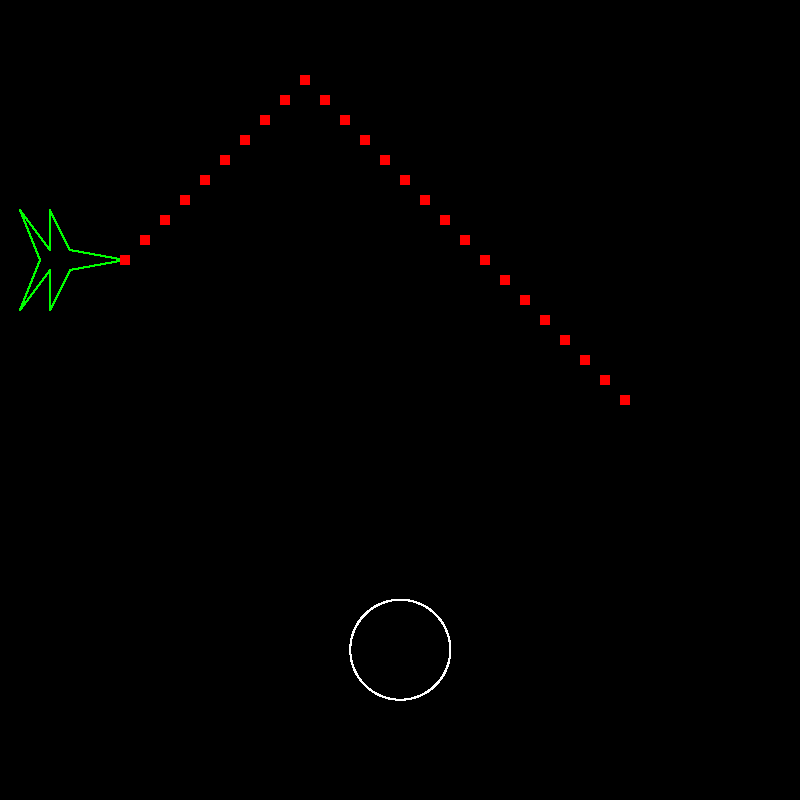

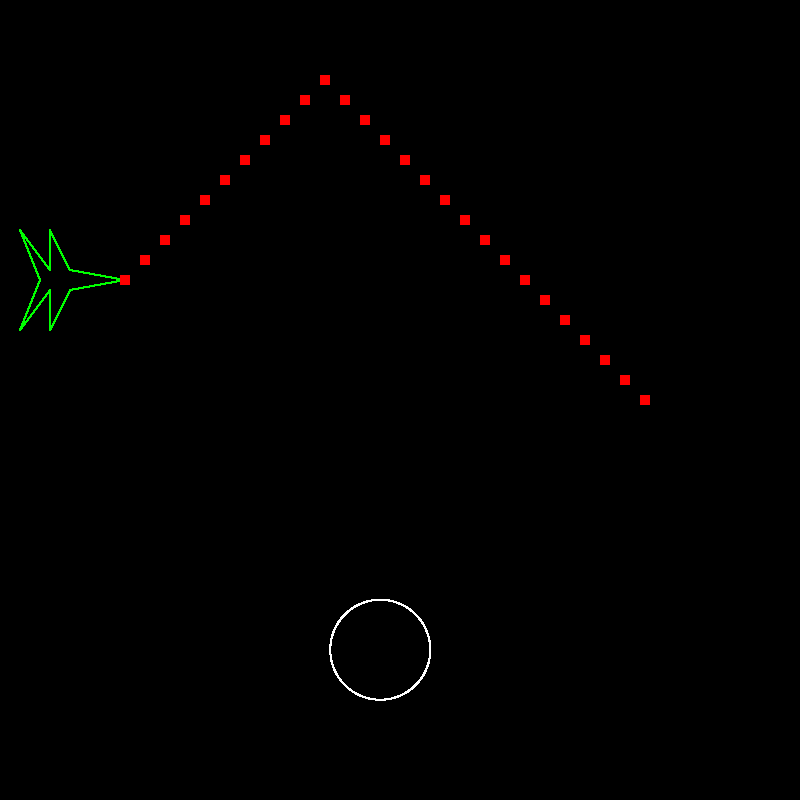

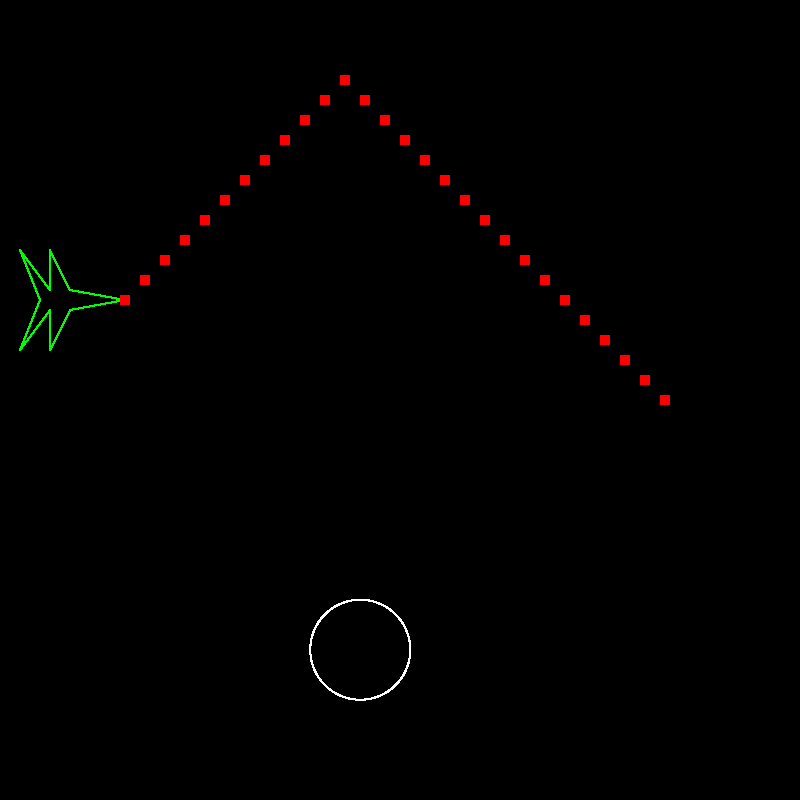

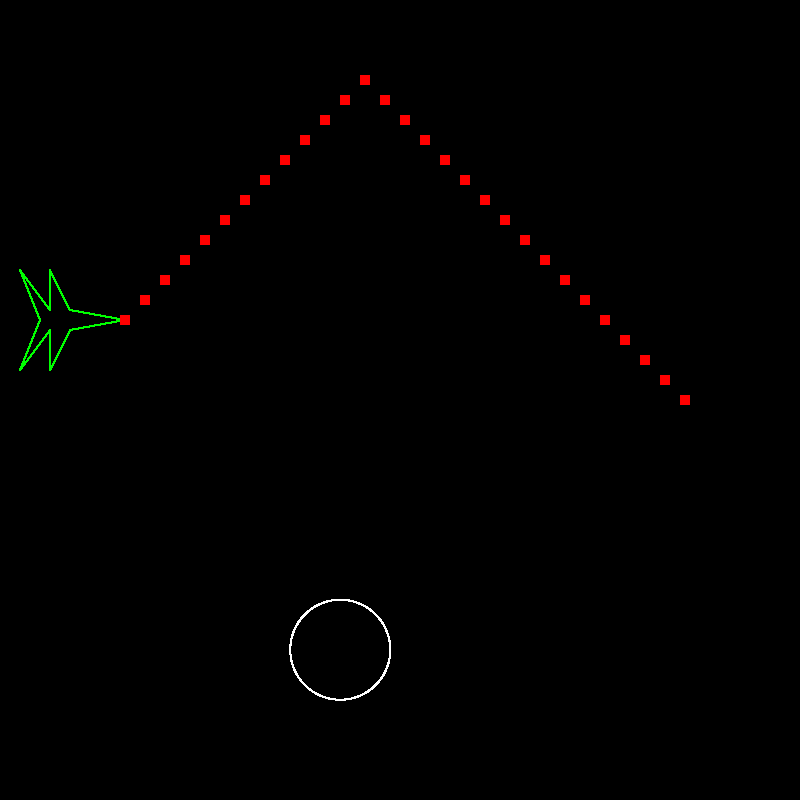

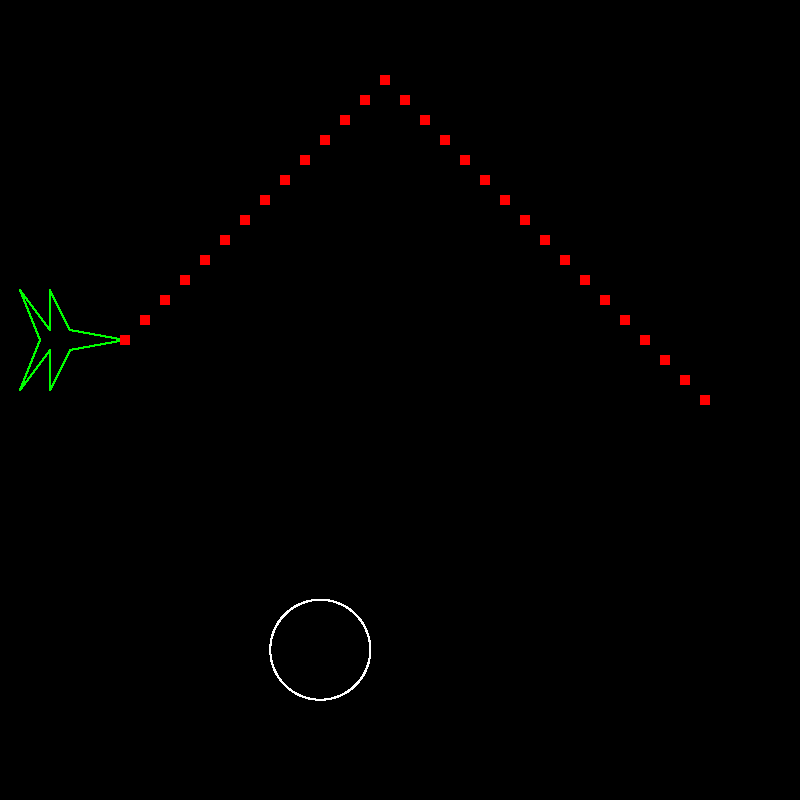

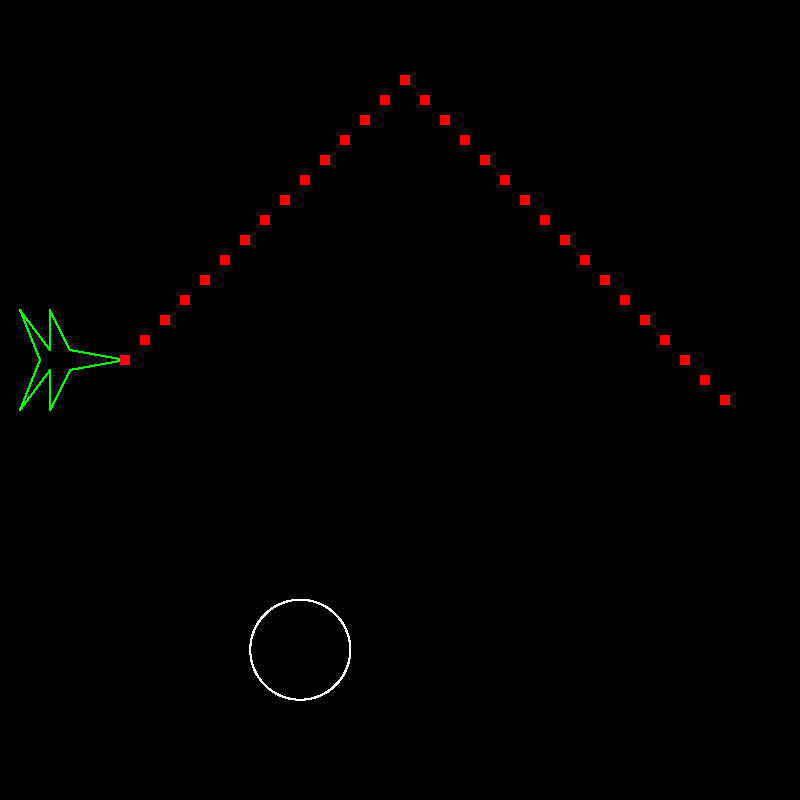

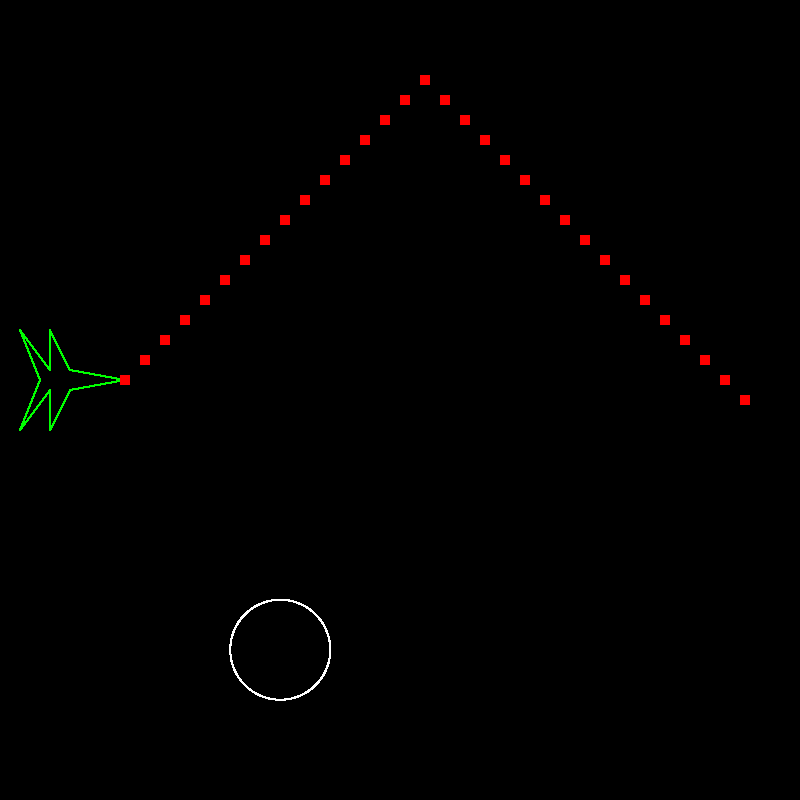

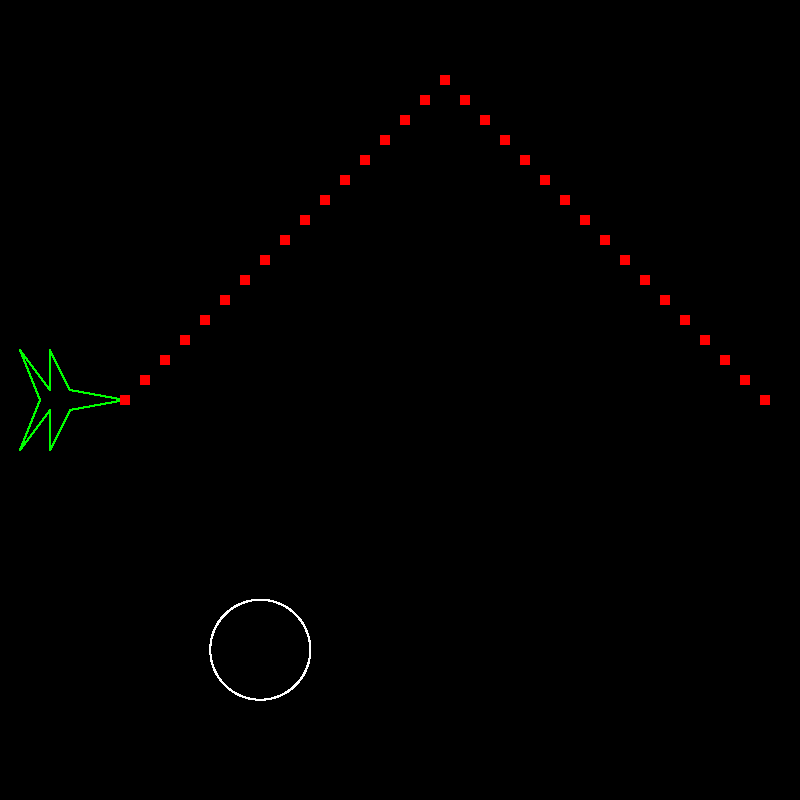

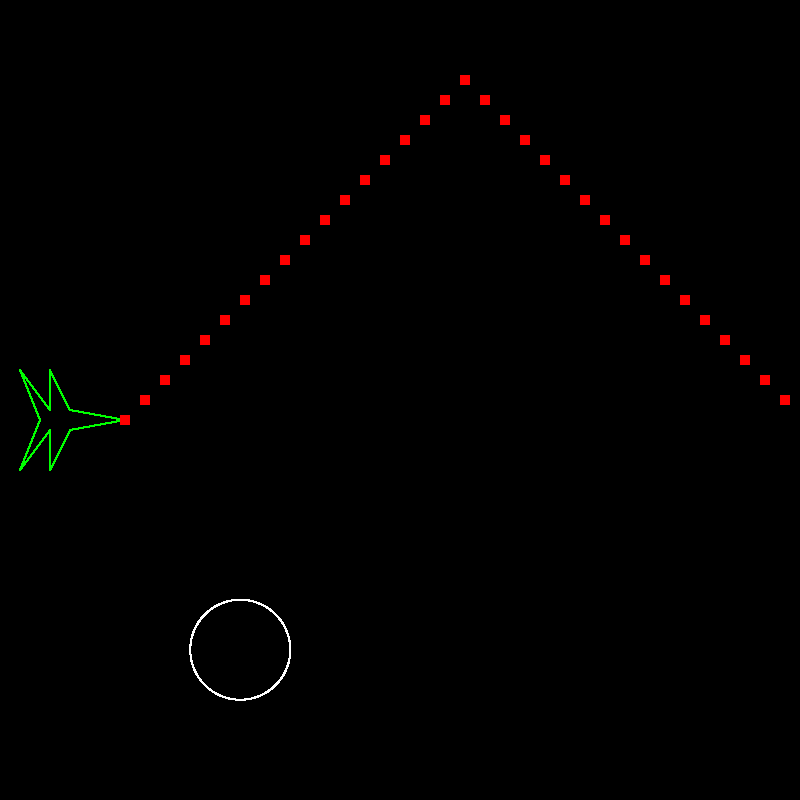

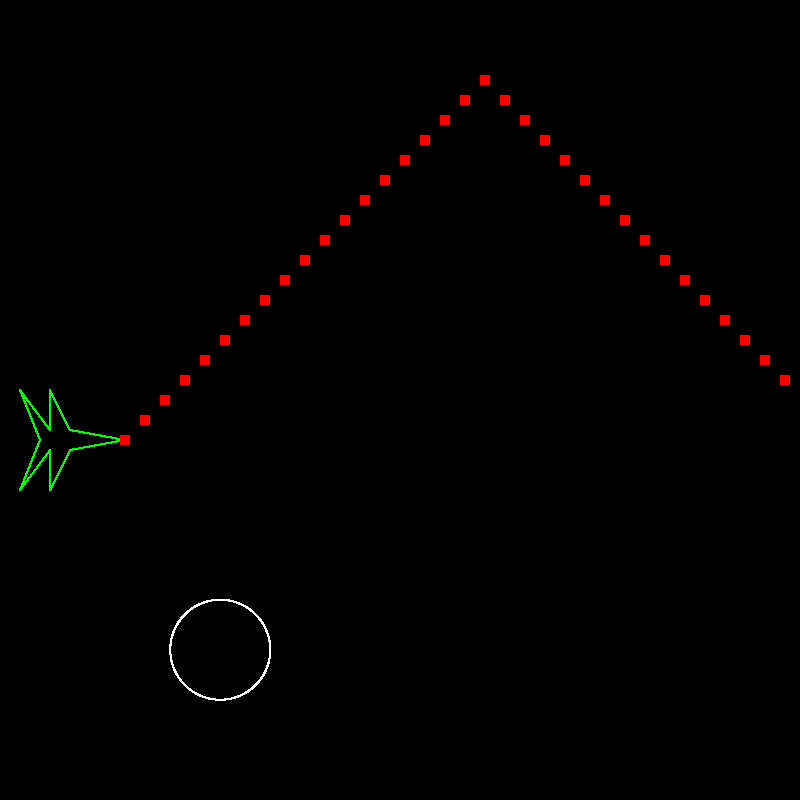

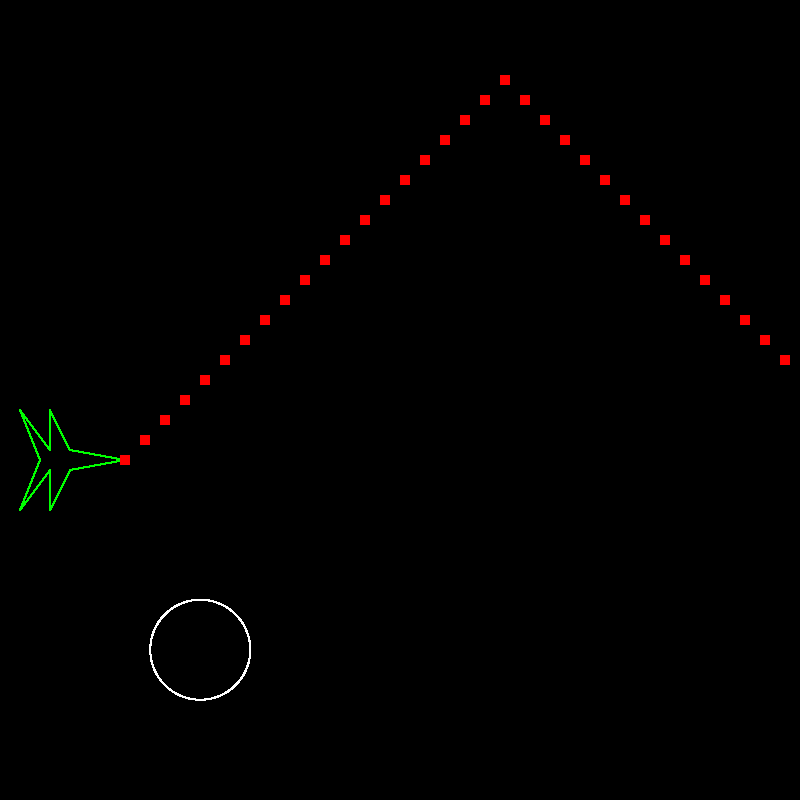

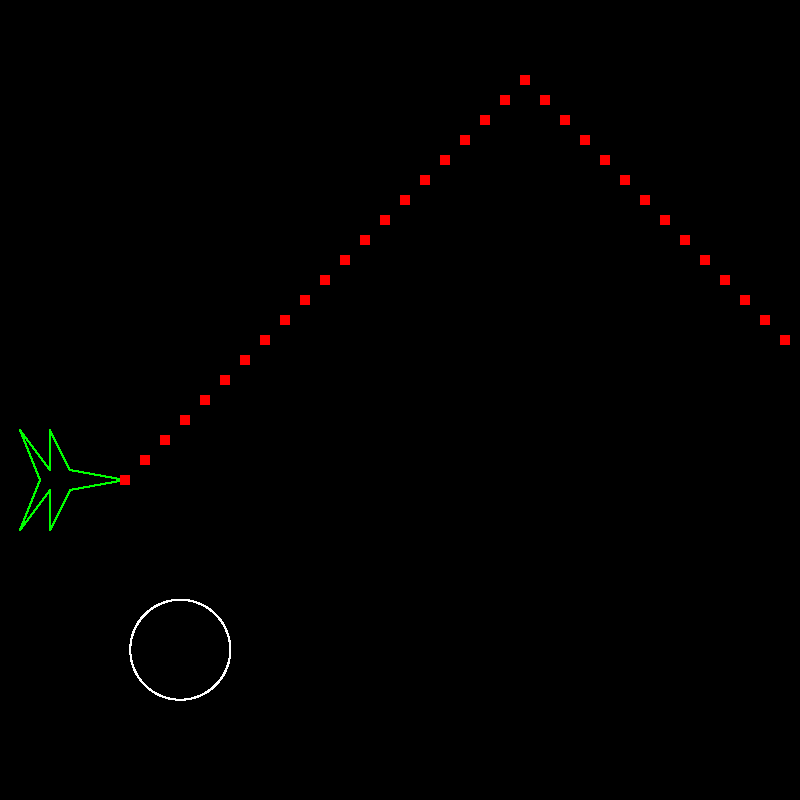

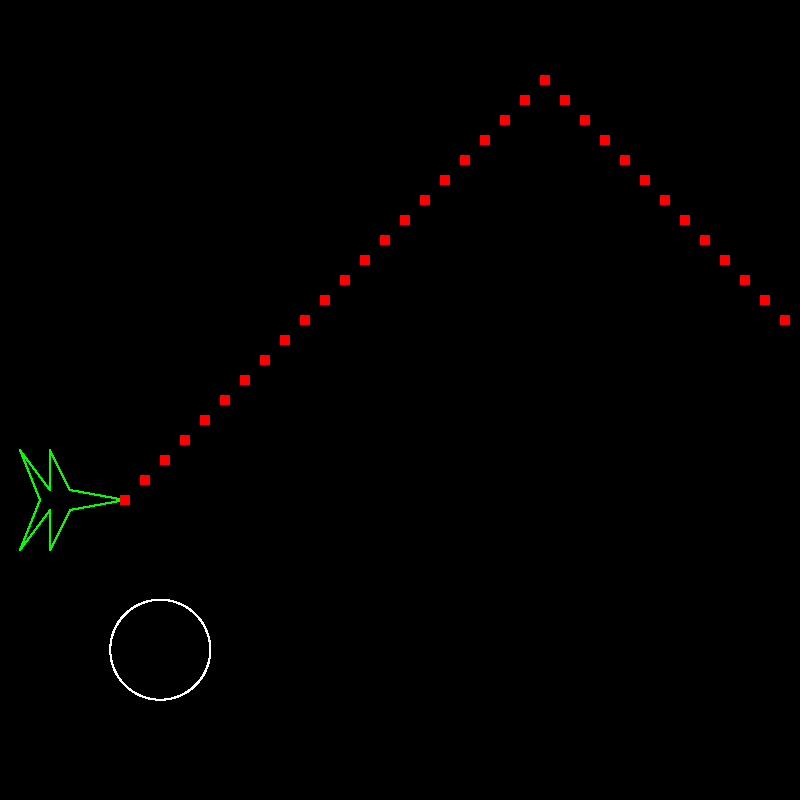

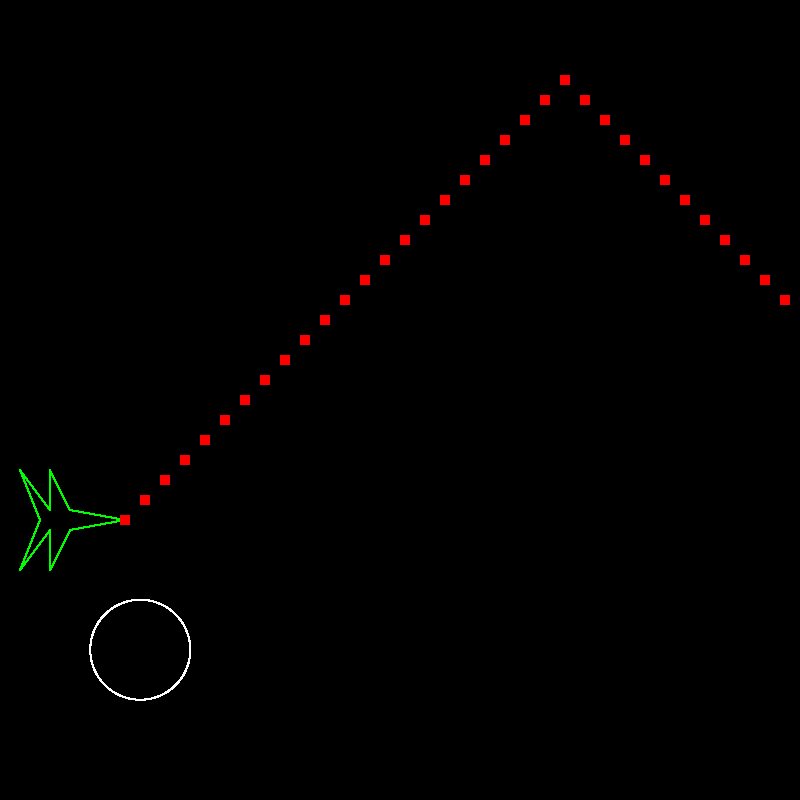

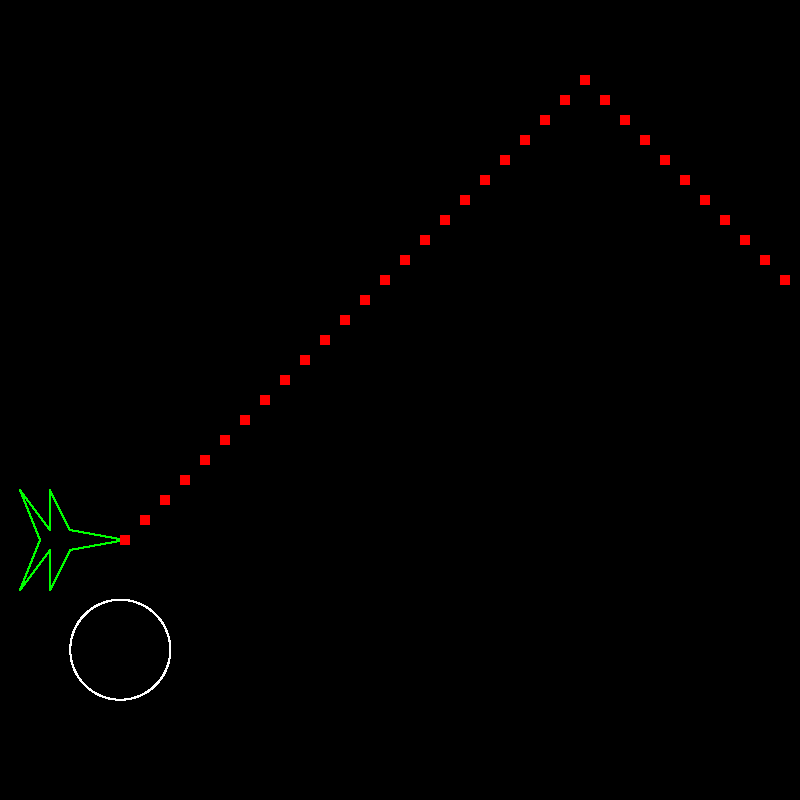

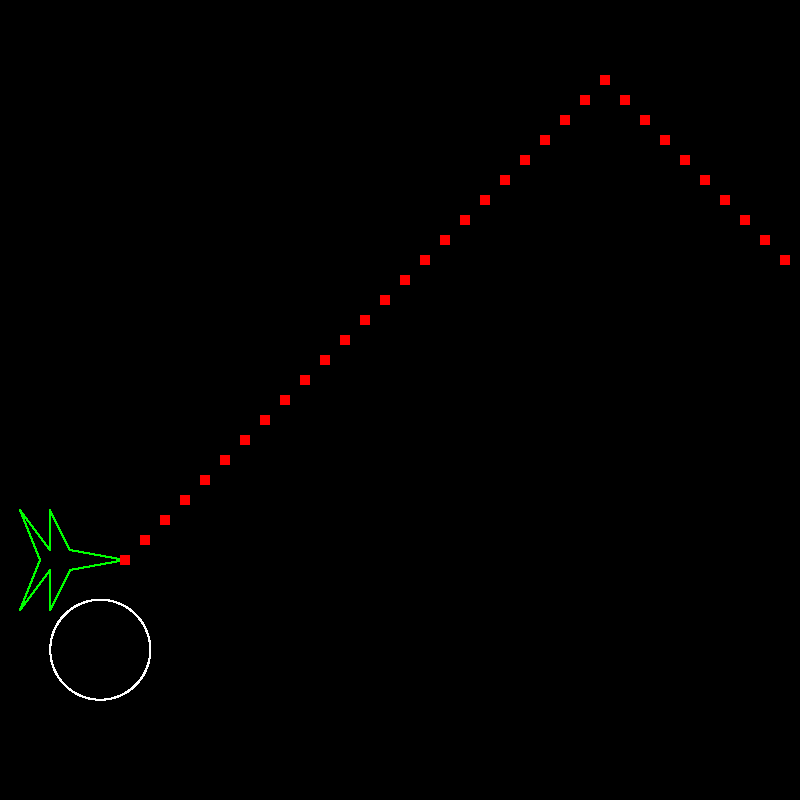

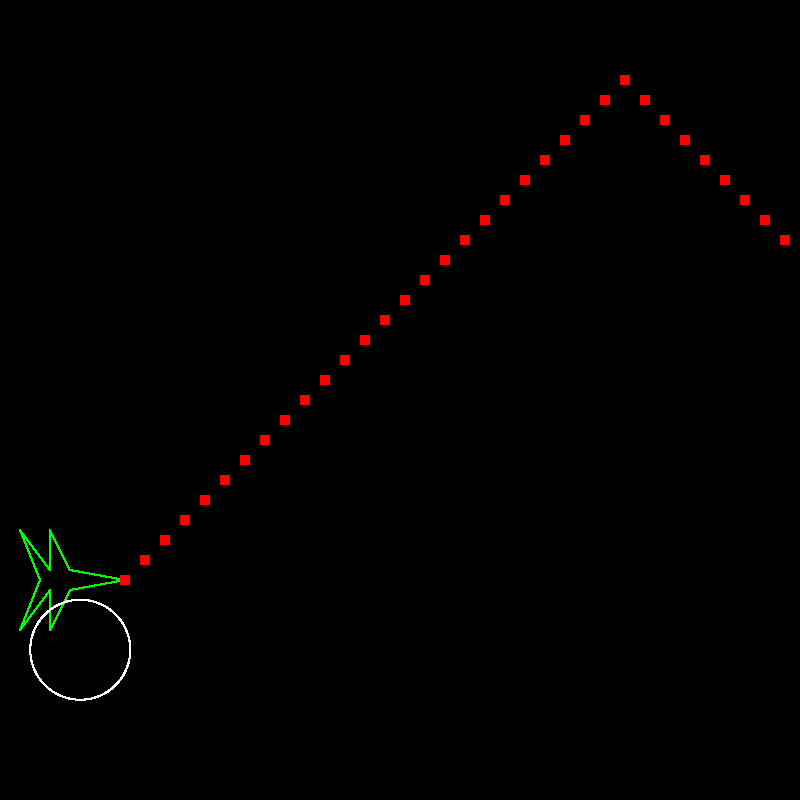

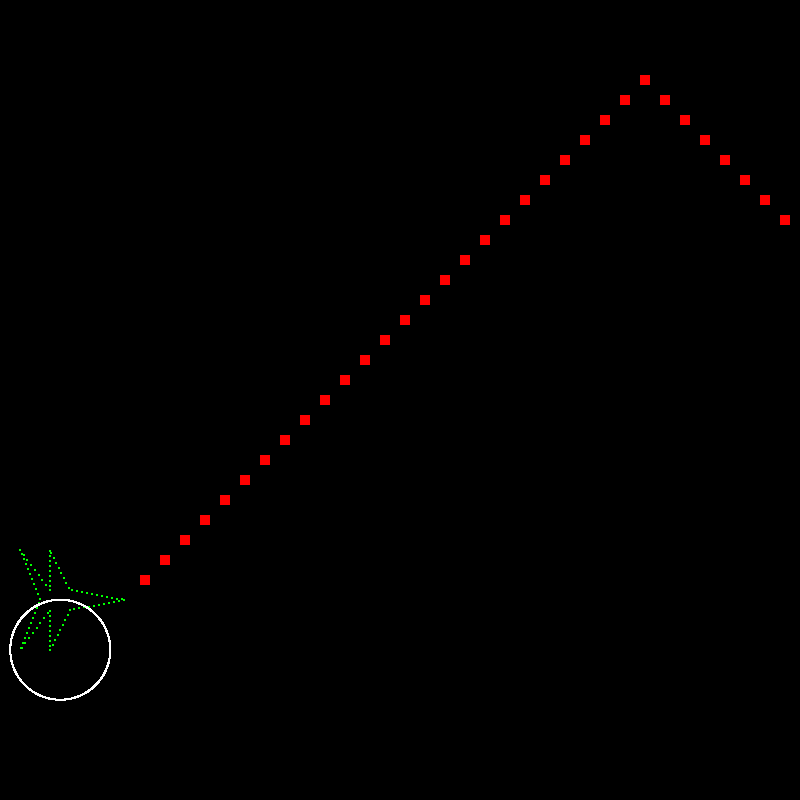

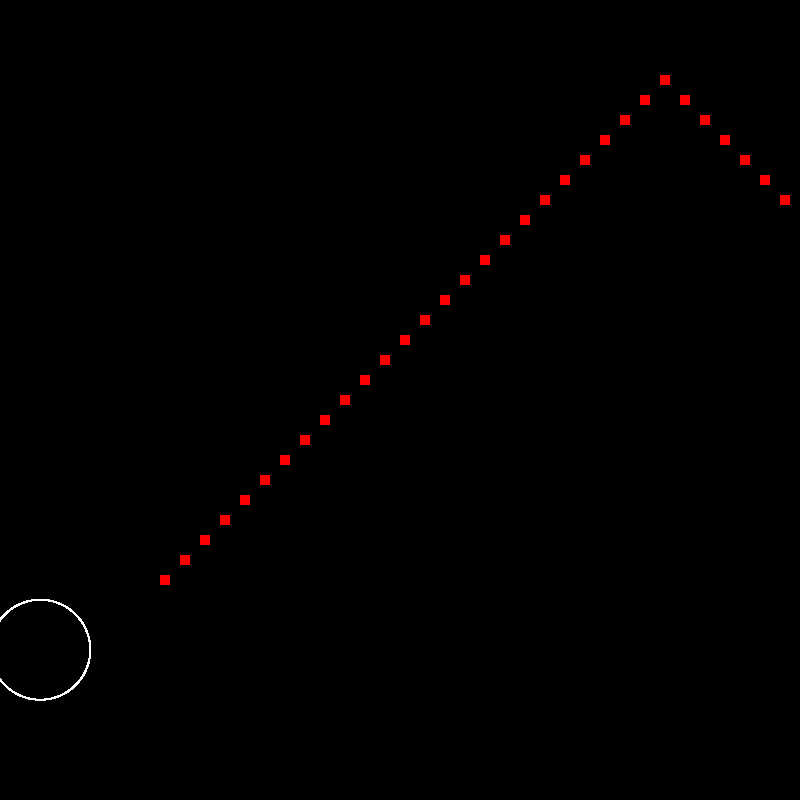

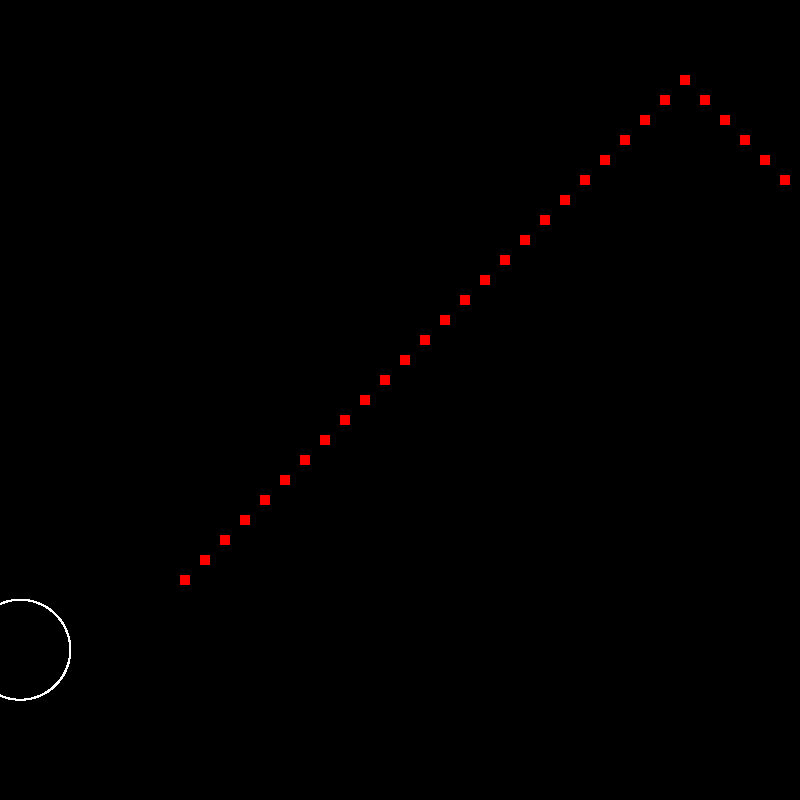

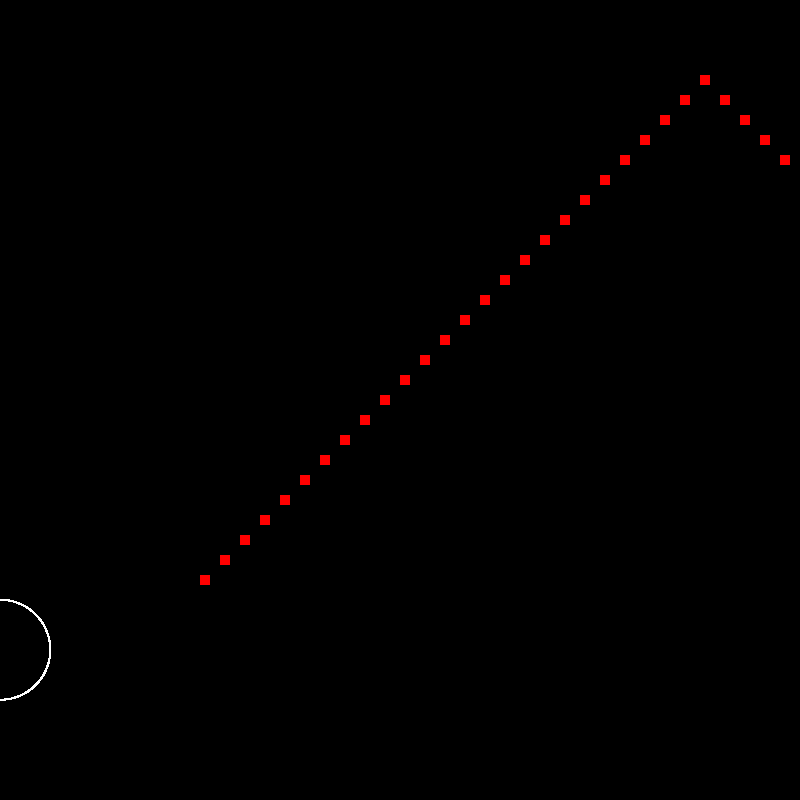

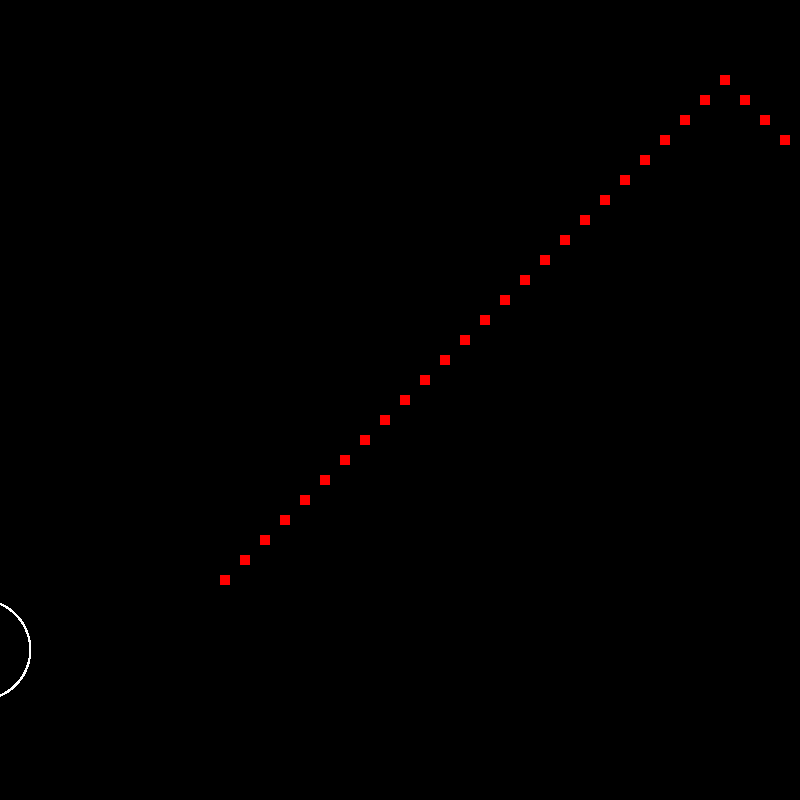

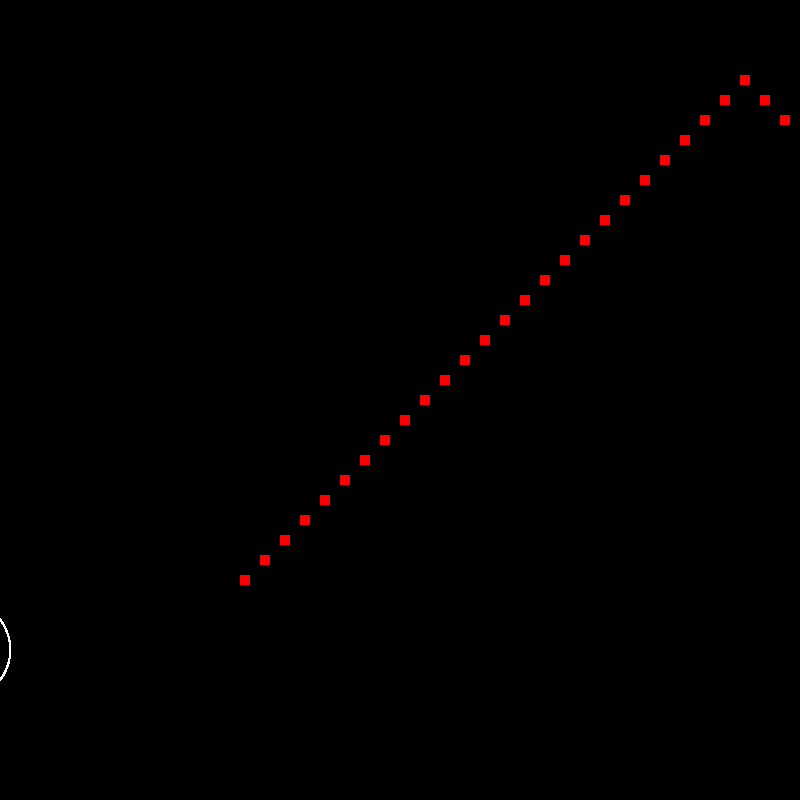

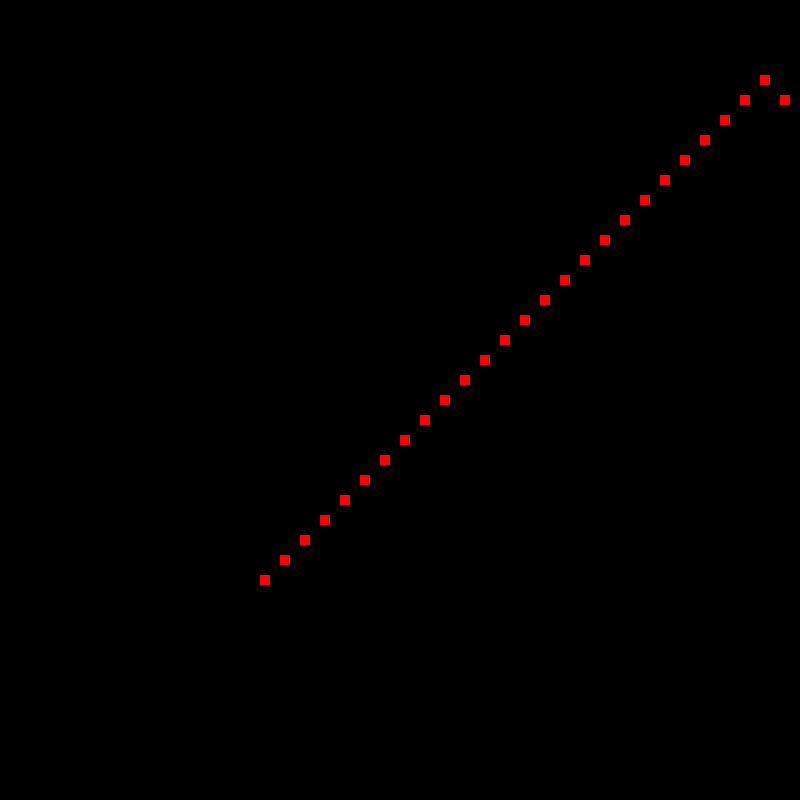

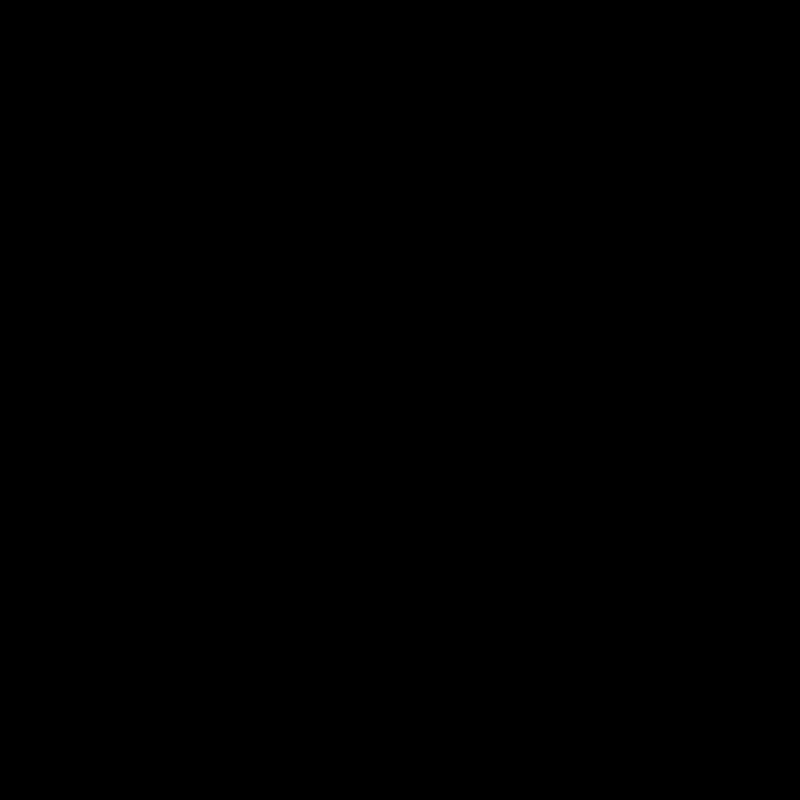

In [ ]:
import time
colors={"red":(1,0,0),"green":(0,1,0),"blue":(0,0,1),"white":(1,1,1)}
planeType={"1":paperPlane1,"2":paperPlane2}
bulletColor=input('Pick a color for bullet from Red,Green,Blue,White:').lower()
planeColor=input('Pick a color for plane from Red,Green,Blue,White:').lower()
planeT=input("Select Type 1 or 2 Plane: ")
paperPlanePoints=planeType[planeT](colors[planeColor])
center0Astroid=astroidOG()
astroidPoints1=astroid1(0.4,350,350,center0Astroid)
astroidPoints2=astroid2(0.5,500,-250,center0Astroid)
astroidPoints3=astroid3(1,600,-50,center0Astroid)
p2x=-(HEIGHT/2)+125
p2y=0
p2=(p2x,p2y)   #pointy edge
listOfBullets=[]
listOfAstroidPoints=[]
time.sleep(5.0)
for i in range(17):
    time.sleep(0.5)
    gl.glClear(gl.GL_COLOR_BUFFER_BIT) #Clear ImageBuffer
    movePaperPlaneY(i,paperPlanePoints,colors[planeColor])
    moveAstroid(i,astroidPoints1)
    moveAstroid(i,astroidPoints2)
    moveAstroid(i,astroidPoints3)
    listOfBullets.append(fireBullet(i,p2,colors[bulletColor]))
    moveBullet(i,listOfBullets,colors[bulletColor])
    imageBuffer()
    j=i
for i in range(15,-17,-1):
    time.sleep(0.5)
    j+=1
    gl.glClear(gl.GL_COLOR_BUFFER_BIT) #Clear ImageBuffer
    if j<42:
        movePaperPlaneY(i,paperPlanePoints,colors[planeColor])
        listOfBullets.append(fireBullet(i,p2,colors[bulletColor]))
        moveBullet(j,listOfBullets,colors[bulletColor])
    elif j==42:
        movePaperPlaneY(i,[paperPlanePoints[x] for x in range(len(paperPlanePoints)) if x%5==0],colors[planeColor])
        moveBullet(j,listOfBullets,colors[bulletColor])
    else:
        moveBullet(j,listOfBullets,colors[bulletColor])
    moveAstroid(j,astroidPoints2)
    if j<=20:
        moveAstroid(j,astroidPoints3)
    elif j==21:
        moveAstroid(j,[astroidPoints3[x] for x in range(len(astroidPoints3)) if x%10==0])
    if j<=23:
        moveAstroid(j,astroidPoints1)
    elif j==24:
       moveAstroid(j,[astroidPoints1[x] for x in range(len(astroidPoints1)) if x%10==0])
    imageBuffer()
gl.glClear(gl.GL_COLOR_BUFFER_BIT) #Clear ImageBuffer
imageBuffer()